In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, roc_curve, precision_score, recall_score, \
                            precision_recall_curve, accuracy_score, silhouette_score, classification_report
from sklearn.preprocessing import StandardScaler
import seaborn
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.impute import KNNImputer
from collections import defaultdict

In [2]:
all_player_stats = pd.read_csv('player_stats.csv')
all_player_stats.drop('Unnamed: 0', axis = 1, inplace = True)

## Data Cleaning

In [3]:
all_player_stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4504 entries, 0 to 4503
Data columns (total 27 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Player  4504 non-null   object 
 1   Pos     4504 non-null   object 
 2   G       4390 non-null   float64
 3   GS      3181 non-null   float64
 4   MP      4233 non-null   float64
 5   FG      4390 non-null   float64
 6   FGA     4390 non-null   float64
 7   FG%     4372 non-null   float64
 8   3P      3373 non-null   float64
 9   3PA     3373 non-null   float64
 10  3P%     2964 non-null   float64
 11  2P      3452 non-null   float64
 12  2PA     3452 non-null   float64
 13  2P%     3423 non-null   float64
 14  eFG%    3435 non-null   float64
 15  FT      4390 non-null   float64
 16  FTA     4390 non-null   float64
 17  FT%     4205 non-null   float64
 18  ORB     3630 non-null   float64
 19  DRB     3630 non-null   float64
 20  TRB     4274 non-null   float64
 21  AST     4390 non-null   float64
 22  

Keeping things consistent - some players played in the NBA, ABA, BAA so we're only considering those who played in the NBA and their respective NBA stats
Removed rows where all stats are blank (these are players who have never played in the NBA - only played in ABA or BAA)

In [4]:
subset = ['G','GS','MP','FG','FGA','FG%','3P','3PA','3P%','2P','2PA','2P%','eFG%','FT','FTA','FT%','ORB','DRB','TRB',
          'AST','STL','BLK','TOV','PF','PTS']
all_player_stats.dropna(subset=subset,axis =0,inplace=True, how ='all') 

Some players are assigned multiple positions because they played different positions for different teams. Since we are using the positions as our targets, we will need to narrow it down to one. We will use the first assigned position listed since that is the position that the player held the most throughout their career.

In [5]:
all_player_stats.Pos.unique()

array(['Power Forward', 'Center and Power Forward', 'Center',
       'Point Guard', 'Shooting Guard',
       'Power Forward, Small Forward, and Center',
       'Small Forward and Power Forward', 'Guard', 'Small Forward',
       'Power Forward and Small Forward',
       'Shooting Guard and Small Forward',
       'Shooting Guard and Point Guard', 'Power Forward and Center',
       'Point Guard and Shooting Guard',
       'Shooting Guard, Small Forward, and Point Guard',
       'Small Forward and Shooting Guard', 'Forward',
       'Power Forward, Small Forward, Shooting Guard, and Point Guard',
       'Center/Forward', 'Guard/Forward', 'Forward/Center',
       'Small Forward and Point Guard',
       'Small Forward, Shooting Guard, and Power Forward',
       'Center, Power Forward, and Small Forward', 'Forward/Guard',
       'Small Forward, Power Forward, and Center',
       'Shooting Guard, Small Forward, and Power Forward',
       'Small Forward, Power Forward, and Shooting Guard',
     

Shooting Guard is the position with the most letters - can use this to filter for players that are assigned multiple positions. Only pull the first position

In [6]:
# players categorized with more than one position
all_player_stats[all_player_stats['Pos'].apply(len) > len('Shooting Guard')]

Player                                       Pos      G  \
1         Zaid Abdul-Aziz                  Center and Power Forward  505.0   
5     Shareef Abdur-Rahim  Power Forward, Small Forward, and Center  830.0   
6           Tom Abernethy           Small Forward and Power Forward  319.0   
14             Quincy Acy           Power Forward and Small Forward  337.0   
15            Alvan Adams                  Center and Power Forward  988.0   
...                   ...                                       ...    ...   
4451       Brandan Wright                  Power Forward and Center  428.0   
4454         Delon Wright            Point Guard and Shooting Guard  319.0   
4465          Tony Wroten            Point Guard and Shooting Guard  145.0   
4481            Sam Young          Small Forward and Shooting Guard  249.0   
4487         Zeke Zawoluk           Power Forward and Small Forward  179.0   

         GS    MP   FG   FGA    FG%   3P  3PA  ...    FT%  ORB  DRB  TRB  AST  \
1       NaN  21.8  3.5   8.2  0.428  NaN  NaN  ...  0.728  2.4  5.4  8.0  1.2   
5     704.0  34.8  6.5  13.9  0.472  0.2  0.6  ...  0.810  2.3  5.3  7.5  2.5   
6       NaN  17.0  2.3   4.6  0.492  0.0  0.0  ...  0.747  1.2  2.0  3.2  1.2   
14     60.0  16.0  1.7   3.9  0.444  0.5  1.6  ...  0.759  0.9  2.6  3.5  0.6   
15    342.0  27.5  5.8  11.6  0.498  0.0  0.0  ...  0.788  2.0  5.0  7.0  4.1   
...     ...   ...  ...   ...    ...  ...  ...  ...    ...  ...  ...  ...  ...   
4451   62.0  16.2  3.0   4.9  0.607  0.0  0.0  ...  0.674  1.4  2.3  3.6  0.5   
4454   54.0  20.9  2.8   6.2  0.451  0.7  1.9  ...  0.795  0.8  2.4  3.2  3.1   
4465   34.0  21.2  4.0   9.6  0.413  0.6  2.5  ...  0.647  0.7  1.8  2.5  3.0   
4481   52.0  15.9  2.2   5.1  0.442  0.2  0.7  ...  0.742  0.7  1.6  2.3  0.7   
4487    NaN  19.7  2.2   5.9  0.372  NaN  NaN  ...  0.767  NaN  NaN  4.1  1.2   

      STL  BLK  TOV   PF   PTS  
1     0.6  1.0  0.9  2.2   9.0  
5     1.0  0.8  2.6  2.8  18.1  
6     0.6  0.2  0.5  1.6   5.6  
14    0.4  0.4  0.6  2.0   4.9  
15    1.3  0.8  2.6  3.3  14.1  
...   ...  ...  ...  ...   ...  
4451  0.5  1.0  0.5  1.3   7.0  
4454  1.1  0.4  1.0  1.2   7.6  
4465  0.9  0.2  2.6  1.8  11.1  
4481  0.5  0.2  0.8  1.2   5.8  
4487  NaN  NaN  NaN  2.5   6.8  

[1290 rows x 27 columns]

In [7]:
# players categorized one position
all_player_stats[all_player_stats['Pos'].apply(len) <= len('Shooting Guard')]

Player             Pos       G     GS    MP    FG   FGA  \
0          Alaa Abdelnaby   Power Forward   256.0   53.0  12.5   2.4   4.8   
2     Kareem Abdul-Jabbar          Center  1560.0  625.0  36.8  10.2  18.1   
3      Mahmoud Abdul-Rauf     Point Guard   586.0  336.0  26.7   6.0  13.6   
4       Tariq Abdul-Wahad  Shooting Guard   236.0  145.0  20.4   3.1   7.3   
7             Forest Able           Guard     1.0    NaN   1.0   0.0   2.0   
...                   ...             ...     ...    ...   ...   ...   ...   
4499          Paul Zipser   Small Forward    98.0   30.0  17.0   1.7   4.6   
4500           Ante Žižić          Center   113.0   27.0  13.4   2.4   4.2   
4501             Jim Zoet          Center     7.0    0.0   4.3   0.1   0.7   
4502            Bill Zopf     Point Guard    53.0    NaN   7.5   0.9   2.5   
4503          Ivica Zubac          Center   271.0  138.0  17.3   3.1   5.3   

        FG%   3P  3PA  ...    FT%  ORB  DRB   TRB  AST  STL  BLK  TOV   PF  \
0     0.502  0.0  0.0  ...  0.701  1.1  2.2   3.3  0.3  0.3  0.3  1.0  1.9   
2     0.559  0.0  0.0  ...  0.721  2.4  7.6  11.2  3.6  0.9  2.6  2.7  3.0   
3     0.442  0.8  2.3  ...  0.905  0.4  1.5   1.9  3.5  0.8  0.1  1.6  1.9   
4     0.417  0.1  0.3  ...  0.703  1.2  2.1   3.3  1.1  0.8  0.4  1.3  2.1   
7     0.000  NaN  NaN  ...    NaN  NaN  NaN   1.0  1.0  NaN  NaN  NaN  1.0   
...     ...  ...  ...  ...    ...  ...  ...   ...  ...  ...  ...  ...  ...   
4499  0.371  0.7  2.1  ...  0.769  0.3  2.3   2.6  0.8  0.4  0.3  0.8  1.7   
4500  0.581  0.0  0.0  ...  0.711  1.3  2.6   3.9  0.6  0.2  0.4  0.7  1.5   
4501  0.200  0.0  0.0  ...    NaN  0.4  0.7   1.1  0.1  0.1  0.4  0.6  1.3   
4502  0.363  NaN  NaN  ...  0.556  NaN  NaN   0.9  1.4  NaN  NaN  NaN  0.6   
4503  0.584  0.0  0.0  ...  0.769  2.1  3.9   6.0  1.0  0.3  0.8  0.9  2.1   

       PTS  
0      5.7  
2     24.6  
3     14.6  
4      7.8  
7      0.0  
...    ...  
4499   4.7  
4500   6.0  
4501   0.3  
4502   2.2  
4503   7.7  

[3100 rows x 27 columns]

Below code takes care of the rows that have multiple positions listed out with commas, have ands or slashes - more cleaning need to be done
Cannot split by '/' and remove with the below code - need both positions to decide what position it is (i.e. if we take the first position it might generically say guard - won't know which guard, second position gives us more insight. Guard/Forward -> Shooting Guard)

In [8]:
# Takes care of the rows that have multiple positions listed out with commas, have ands or slashes - more cleaning need to be done
all_player_stats['Target'] = all_player_stats['Pos'].apply(lambda x: x.split(',')[0] if ',' in x else x.split(',')[0].split(' and ')[0])


In [9]:
all_player_stats['Target'].unique()

array(['Power Forward', 'Center', 'Point Guard', 'Shooting Guard',
       'Small Forward', 'Guard', 'Forward', 'Center/Forward',
       'Guard/Forward', 'Forward/Center', 'Forward/Guard',
       'Point Guard\n'], dtype=object)

There are 156 players that are categorized generically as a guard or a forward - hard to put them in a position without looking at them individually and make judgement calls on my end. Will be dropping these players from the dataset which is only about 3.4%

In [10]:
index = all_player_stats.index
condition = (all_player_stats['Target']=='Guard') | (all_player_stats['Target']=='Forward')
rows_to_drop_indices = index[condition]
all_player_stats.drop(rows_to_drop_indices, axis = 0, inplace=True)

all_player_stats['Target'].unique()

array(['Power Forward', 'Center', 'Point Guard', 'Shooting Guard',
       'Small Forward', 'Center/Forward', 'Guard/Forward',
       'Forward/Center', 'Forward/Guard', 'Point Guard\n'], dtype=object)

In [11]:
all_player_stats['Target'].replace(['Center/Forward','Guard/Forward','Forward/Center','Forward/Guard','Point Guard\n'],
                        ['Center', 'Shooting Guard','Power Forward', 'Small Forward', 'Point Guard'], inplace = True)
# double check targets to see if they're the 5 intended
all_player_stats['Target'].unique()

array(['Power Forward', 'Center', 'Point Guard', 'Shooting Guard',
       'Small Forward'], dtype=object)

Add in another feature: 1 - multiple positions, 0 - single position, see if this improves out model. Only meant to use informatively, cannot use for final model! It would be cheating!

In [12]:
all_player_stats['Num_Pos'] = all_player_stats['Pos'].apply(len) > len('Shooting Guard')
classify = {True:1, False:0}
all_player_stats['Num_Pos'] = all_player_stats['Num_Pos'].map(classify)

In [13]:
all_player_stats.head()

Player                       Pos       G     GS    MP    FG  \
0       Alaa Abdelnaby             Power Forward   256.0   53.0  12.5   2.4   
1      Zaid Abdul-Aziz  Center and Power Forward   505.0    NaN  21.8   3.5   
2  Kareem Abdul-Jabbar                    Center  1560.0  625.0  36.8  10.2   
3   Mahmoud Abdul-Rauf               Point Guard   586.0  336.0  26.7   6.0   
4    Tariq Abdul-Wahad            Shooting Guard   236.0  145.0  20.4   3.1   

    FGA    FG%   3P  3PA  ...  DRB   TRB  AST  STL  BLK  TOV   PF   PTS  \
0   4.8  0.502  0.0  0.0  ...  2.2   3.3  0.3  0.3  0.3  1.0  1.9   5.7   
1   8.2  0.428  NaN  NaN  ...  5.4   8.0  1.2  0.6  1.0  0.9  2.2   9.0   
2  18.1  0.559  0.0  0.0  ...  7.6  11.2  3.6  0.9  2.6  2.7  3.0  24.6   
3  13.6  0.442  0.8  2.3  ...  1.5   1.9  3.5  0.8  0.1  1.6  1.9  14.6   
4   7.3  0.417  0.1  0.3  ...  2.1   3.3  1.1  0.8  0.4  1.3  2.1   7.8   

           Target  Num_Pos  
0   Power Forward        0  
1          Center        1  
2          Center        0  
3     Point Guard        0  
4  Shooting Guard        0  

[5 rows x 29 columns]

## Prelim EDA

In [14]:
all_player_stats.describe()

G           GS           MP           FG          FGA  \
count  4234.000000  3181.000000  4142.000000  4234.000000  4234.000000   
mean    295.242088   141.156869    16.821704     2.542844     5.857865   
std     316.689540   235.404736     8.918755     1.848600     3.919277   
min       1.000000     0.000000     0.000000     0.000000     0.000000   
25%      41.000000     0.000000     9.500000     1.200000     2.900000   
50%     153.000000    22.000000    15.900000     2.100000     4.900000   
75%     501.750000   178.000000    23.400000     3.400000     8.000000   
max    1611.000000  1471.000000    45.800000    12.100000    23.800000   

               FG%           3P          3PA          3P%           2P  ...  \
count  4217.000000  3372.000000  3372.000000  2963.000000  3450.000000  ...   
mean      0.420155     0.345907     1.041044     0.248714     2.190029  ...   
std       0.095464     0.499318     1.343152     0.155824     1.742169  ...   
min       0.000000     0.000000     0.000000     0.000000     0.000000  ...   
25%       0.383000     0.000000     0.000000     0.152000     0.900000  ...   
50%       0.430000     0.100000     0.400000     0.286000     1.700000  ...   
75%       0.469000     0.500000     1.700000     0.348000     3.000000  ...   
max       1.000000     3.700000     8.500000     1.000000    10.800000  ...   

               ORB          DRB          TRB          AST          STL  \
count  3629.000000  3629.000000  4165.000000  4234.000000  3601.000000   
mean      0.877074     2.030973     3.052725     1.493269     0.553430   
std       0.707429     1.504986     2.289070     1.402677     0.399034   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.400000     0.900000     1.400000     0.500000     0.300000   
50%       0.700000     1.700000     2.500000     1.100000     0.500000   
75%       1.200000     2.700000     4.100000     2.000000     0.800000   
max       5.100000    10.500000    22.900000    11.200000     2.700000   

               BLK          TOV           PF          PTS      Num_Pos  
count  3601.000000  3463.000000  4234.000000  4234.000000  4234.000000  
mean      0.321161     1.051516     1.784766     6.655007     0.304676  
std       0.382168     0.691169     0.844228     4.868962     0.460325  
min       0.000000     0.000000     0.000000     0.000000     0.000000  
25%       0.100000     0.600000     1.100000     3.000000     0.000000  
50%       0.200000     0.900000     1.800000     5.400000     0.000000  
75%       0.400000     1.400000     2.400000     9.000000     1.000000  
max       3.500000     4.200000     5.000000    30.100000     1.000000  

[8 rows x 26 columns]

From the above chart it shows min games played by someone is 1 game! Should drop players that only played a few games since stats are per game. Data is total career averages - those who played very litte games, the data might not be representative of their true performance i.e. could be a rookie (since this is career total for all basketball players thus far which includes current rookies, or it could be a 10-day contract deal like Antonio Anderson had done with OKC). Per season - each team plays 82 games.

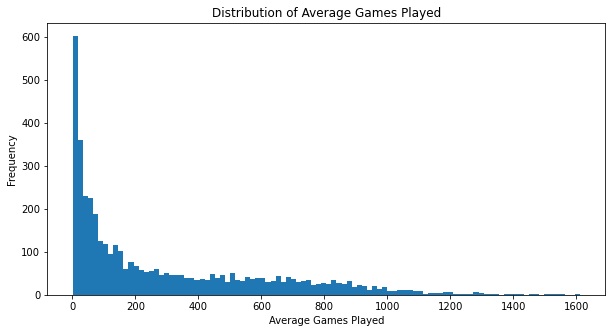

In [15]:
all_player_stats['G'].hist(grid=False,bins=100,figsize=(10,5))
plt.xlabel('Average Games Played')
plt.ylabel('Frequency')
plt.title('Distribution of Average Games Played');

Looking at the distribution of average games played - there isn't an obvious threshold of min games played to consider. Doing intuitively - given that there are 82 games in a season, and not all players play for the whole game, I would say drop players that have played <20 games (~ 1/4 of a season

In [16]:
# dropping players that played less than 20 games in their total career
all_player_stats = all_player_stats[all_player_stats['G'] >=20]

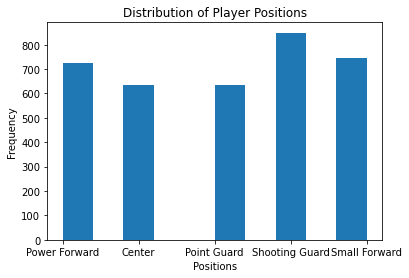

In [17]:
# Positions are pretty evenly distributed
fig,ax = plt.subplots()
ax.hist(all_player_stats['Target'])
ax.set_xlabel('Positions')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Player Positions');

In [18]:
summary = all_player_stats.groupby('Target').mean()
summary

G          GS         MP        FG       FGA  \
Target                                                                  
Center          378.150943  186.788732  17.486591  2.651101  5.573742   
Point Guard     376.148265  177.647410  20.189274  2.941009  6.945110   
Power Forward   357.488243  164.027076  18.066619  2.754080  6.110512   
Shooting Guard  306.733804  148.584459  18.448848  2.962191  6.989164   
Small Forward   330.427041  171.608187  18.478493  2.903481  6.668273   

                     FG%        3P       3PA       3P%        2P  ...  \
Target                                                            ...   
Center          0.470283  0.064535  0.209884  0.151496  2.515720  ...   
Point Guard     0.412360  0.565348  1.668550  0.295758  2.393333  ...   
Power Forward   0.447169  0.226976  0.696220  0.222309  2.494975  ...   
Shooting Guard  0.412163  0.592031  1.704375  0.295231  2.437500  ...   
Small Forward   0.425000  0.444746  1.302174  0.272854  2.557292  ...   

                     ORB       DRB       TRB       AST       STL       BLK  \
Target                                                                       
Center          1.522342  3.163964  4.954808  0.936635  0.417122  0.773042   
Point Guard     0.461141  1.590374  2.132808  3.367192  0.849910  0.128725   
Power Forward   1.385089  2.924311  4.498731  1.056846  0.507061  0.467816   
Shooting Guard  0.584263  1.583691  2.237304  1.782450  0.675793  0.186888   
Small Forward   0.951050  2.188530  3.322177  1.289157  0.619870  0.295114   

                     TOV        PF       PTS   Num_Pos  
Target                                                  
Center          1.056926  2.257547  6.762264  0.251572  
Point Guard     1.495028  1.760568  7.873502  0.269716  
Power Forward   1.051265  2.119779  7.131120  0.423237  
Shooting Guard  1.150379  1.716608  7.822026  0.395760  
Small Forward   1.085095  1.882329  7.593708  0.390897  

[5 rows x 26 columns]

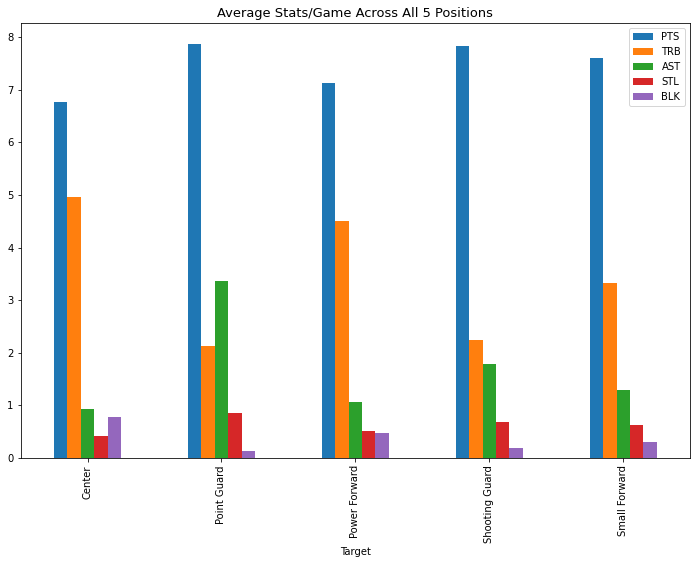

In [19]:
bar_chart_df = summary[['PTS', 'TRB', 'AST', 'STL', 'BLK']]
bar_chart_df.plot(kind='bar', figsize = (12, 8))
plt.title('Average Stats/Game Across All 5 Positions',fontsize=13);

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


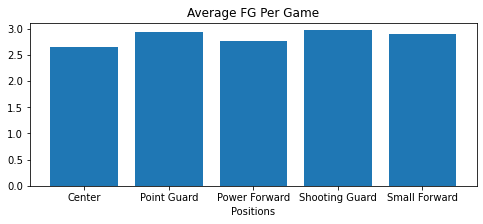

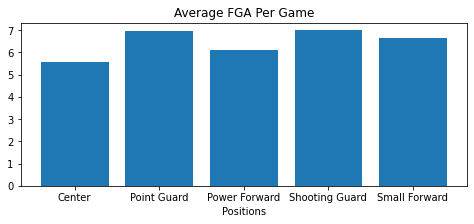

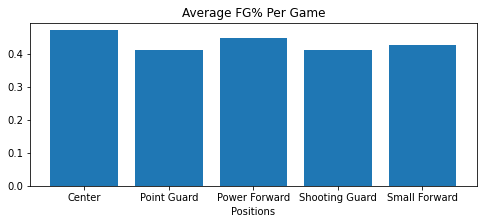

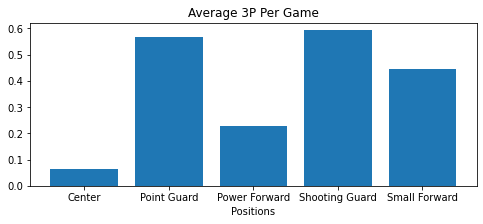

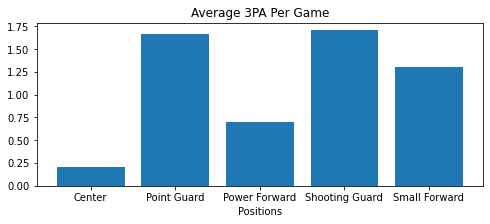

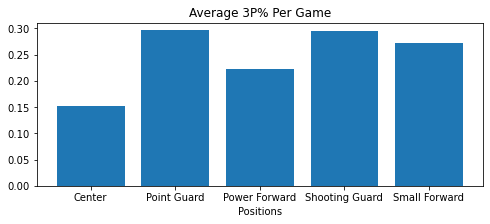

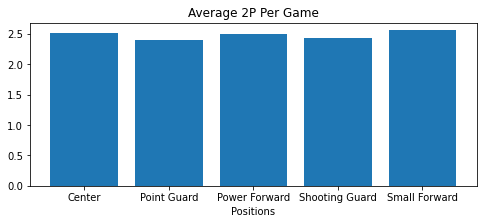

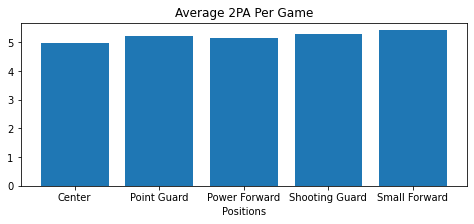

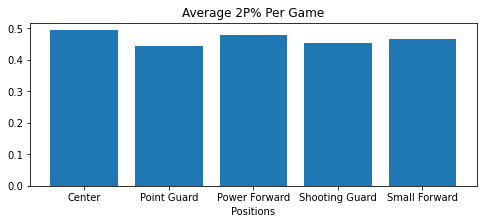

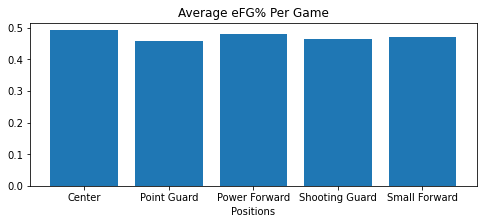

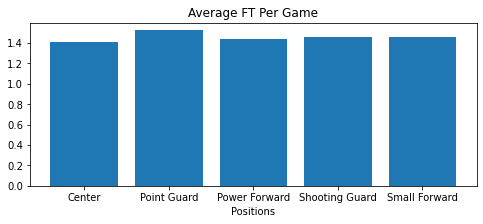

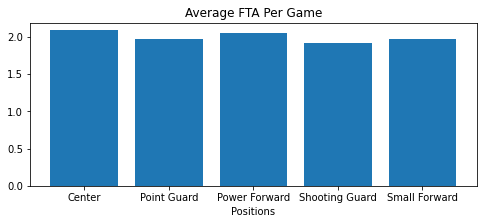

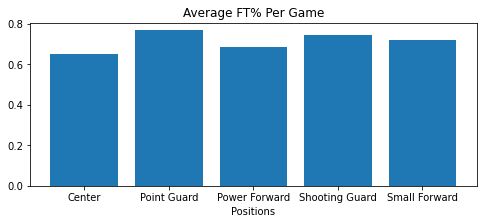

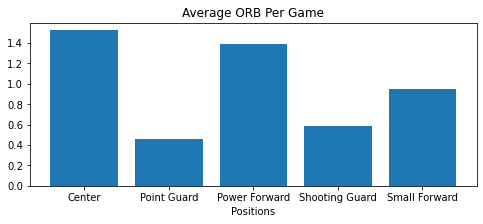

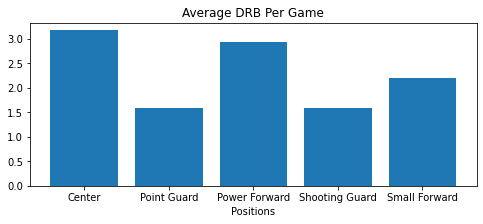

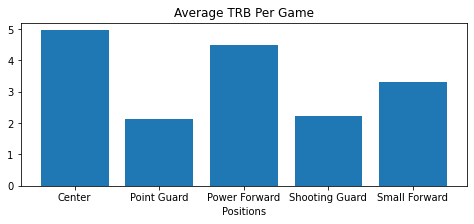

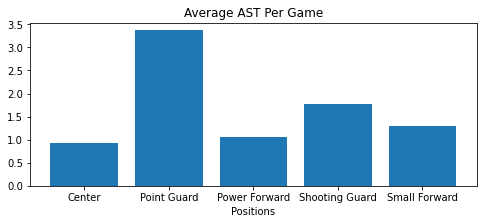

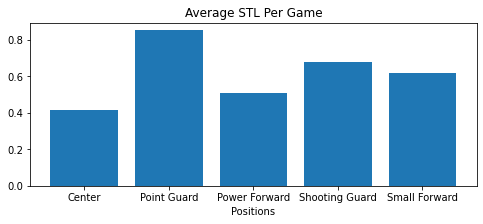

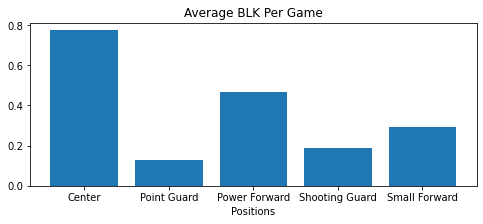

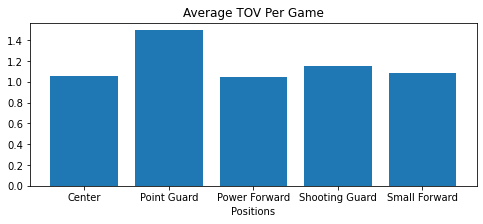

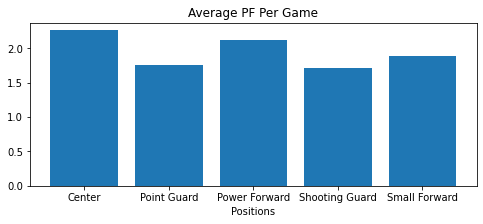

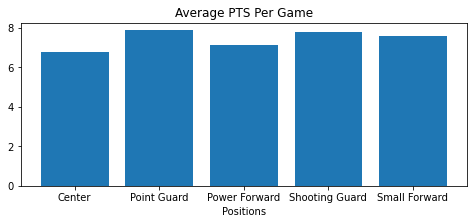

In [20]:
for feature in summary.drop(['Num_Pos','G','GS','MP'],axis=1).columns:
    fig, ax = plt.subplots(figsize = (8,3))
    ax.bar(summary.index, summary[feature])
    ax.set_xlabel('Positions')
    ax.set_title(f'Average {feature} Per Game');

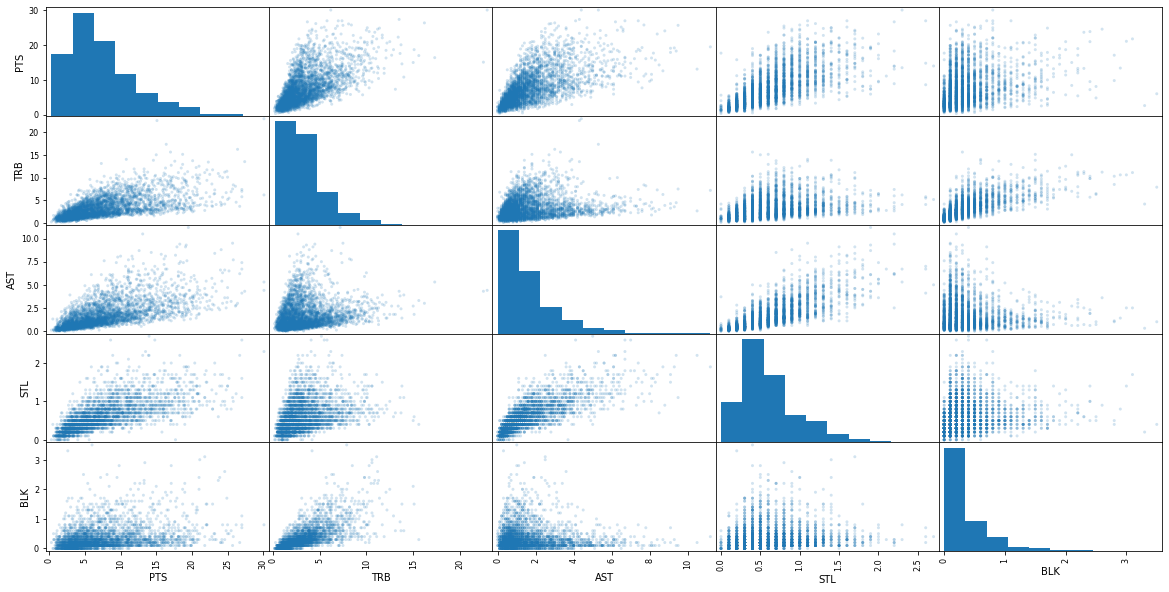

In [21]:
pd.plotting.scatter_matrix(all_player_stats[['PTS', 'TRB', 'AST', 'STL', 'BLK']], alpha=0.2, figsize = (20,10));

## Random Forest

In [22]:
def random_forest(df,model_features,drop_na=True, gini = True, confusion_matrix = True,roc=True):
    
    if drop_na == True:
        total_features = model_features + ['Target']
        df = df[total_features].dropna(axis=0)
        X = df[model_features]
        y = df['Target']
    else:
        X = df[model_features]
        y = df['Target']
    
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.20, random_state = 23, stratify = y)
    rf = RandomForestClassifier().fit(X_train,y_train)
    print(f'train accuracy: {cross_val_score(rf,X_train,y_train,cv=5).mean()} | test accuracy: {rf.score(X_test,y_test)}')
    
    if gini == True:
        feat_scores = pd.Series(rf.feature_importances_,
                               index=X_train.columns)
        feat_scores = feat_scores.sort_values()
        ax = feat_scores.plot(kind='barh',
                              color='b')
        ax.set_title('Average Gini Importance')
        ax.set_xlabel('Average contribution to information gain')
    
    if roc == True: 
        predicted_prob = rf.predict_proba(X_test)
        fig, axs = plt.subplots(1,2, figsize=(18.75,10))
        y_test_dummy = pd.get_dummies(y_test).values
        labels = ['Power Forward', 'Center', 'Point Guard', 'Shooting Guard',
           'Small Forward']
        for i in range(5):
            # ROC Curve
            fpr,tpr,thresholds = roc_curve(y_test_dummy[:,i],predicted_prob[:,i])
            axs[0].plot(fpr,tpr,lw=3,label=labels[i])#,color=colors[i])
            axs[0].plot([0,1],[0,1],color='k',ls='--')
            axs[0].set_xlabel('False Positive Rate')
            axs[0].set_ylabel('True Positive Rate')
            axs[0].legend()
            axs[0].set_title('ROC Curve')
            # Precision-Recall Curve
            precision,recall,thresholds = precision_recall_curve(y_test_dummy[:,i],predicted_prob[:,i])
            axs[1].plot(recall,precision,label=labels[i])#,color=colors[i])
            axs[1].set_xlabel('Recall')
            axs[1].set_ylabel('Precision')
            axs[1].set_title('Precision-Recall Curve')
            axs[1].legend() 
    
    if confusion_matrix == True:
        plot_confusion_matrix(rf,X_test,y_test,xticks_rotation='vertical');

### Baseline Model with 5 Main Stats

In [23]:
# check how many rows have NaNs
is_NaN = all_player_stats[['PTS', 'TRB', 'AST', 'STL', 'BLK']].isnull()
row_has_NaN = is_NaN.any(axis=1)
print(row_has_NaN.sum())

# percent we would be dropping
print((566/all_player_stats.shape[0]) * 100)

566
15.770409584842573


train accuracy: 0.6294380849716819 | test accuracy: 0.631404958677686


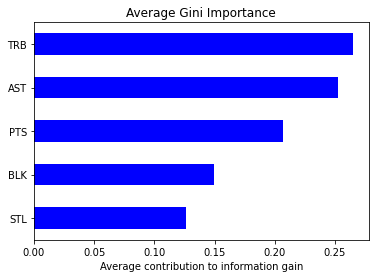

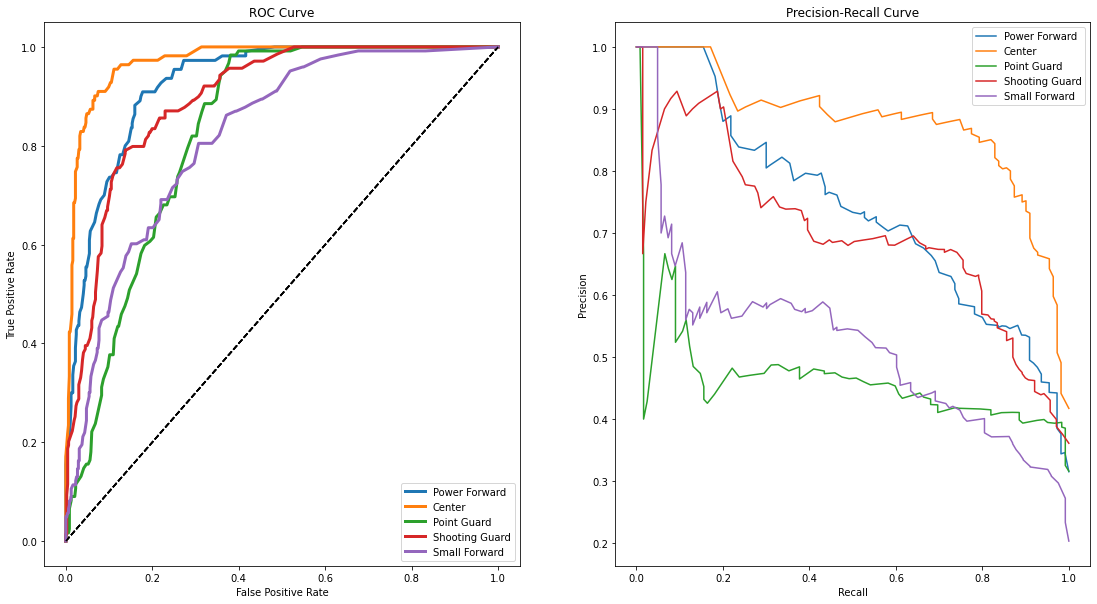

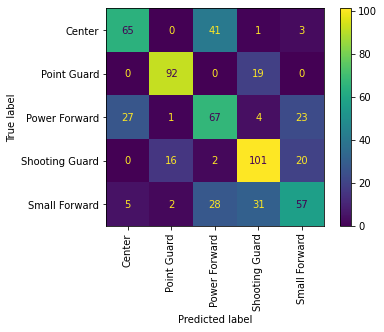

In [24]:
model_features = ['PTS', 'TRB', 'AST', 'STL', 'BLK']
random_forest(all_player_stats,model_features)

Investigate where we are getting wrong

In [25]:
total_features = model_features + ['Target']
df = all_player_stats[total_features].dropna(axis=0)
X = df[model_features]
y = df['Target']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.20, random_state = 23, stratify = y)

rf = RandomForestClassifier().fit(X_train,y_train)

y_predicted = rf.predict(X_test)
test_with_player_names = pd.concat([X_test,pd.DataFrame(all_player_stats[['Player','Target','Num_Pos']])],axis =1, join = 'inner')
actual_predicted = pd.concat([test_with_player_names.reset_index(),pd.DataFrame(data=y_predicted, columns = ['Predicted'])],axis = 1)


In [26]:
misclassified = actual_predicted[actual_predicted['Target']!=actual_predicted['Predicted']]
single_position_misclassification = (misclassified['Num_Pos'].value_counts()[0]/test_with_player_names['Num_Pos'].value_counts()[0])
multiple_position_misclassification = (misclassified['Num_Pos'].value_counts()[1]/test_with_player_names['Num_Pos'].value_counts()[1])
print(f'misclassified those that were assigned one position: {round(single_position_misclassification*100)}%')
print(f'misclassified those that were assigned multiple positions: {round(multiple_position_misclassification*100)}%')

misclassified those that were assigned one position: 37%
misclassified those that were assigned multiple positions: 42%


How is our model currently categorizing players based on the metrics? The areas that are mixing up our Centers/Power Forwards are pretty intuitive in terms of where they are overlapping and where the model is misclassifying. i.e. Centers/Power Forwards are traditionally the bigger men on the court and have higher blocks and rebounds vs Shooting Guard/ Power Forwards are smaller and tend to do better in points and assists. Will need more features to inform the model.

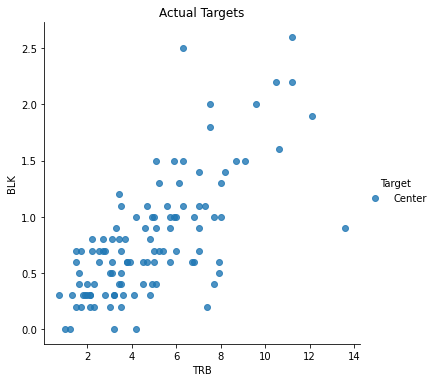

In [27]:
just_center = actual_predicted[actual_predicted['Target']== 'Center']
seaborn.lmplot(x='TRB',y='BLK', data=just_center,hue='Target', fit_reg =False)
plt.title('Actual Targets');

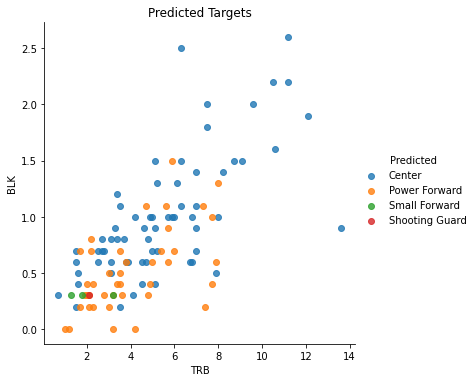

In [28]:
seaborn.lmplot(x='TRB',y='BLK', data=just_center,hue='Predicted', fit_reg =False)
plt.title('Predicted Targets');

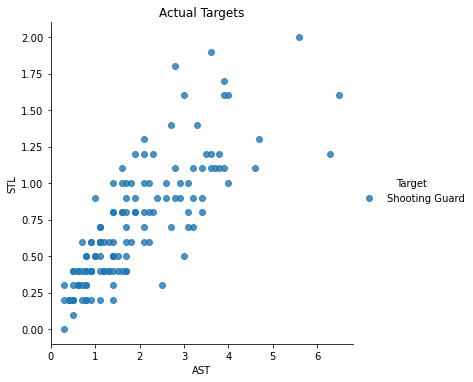

In [29]:
just_sg = actual_predicted[actual_predicted['Target']== 'Shooting Guard']
seaborn.lmplot(x='AST',y='STL', data=just_sg,hue='Target', fit_reg =False)
plt.title('Actual Targets');

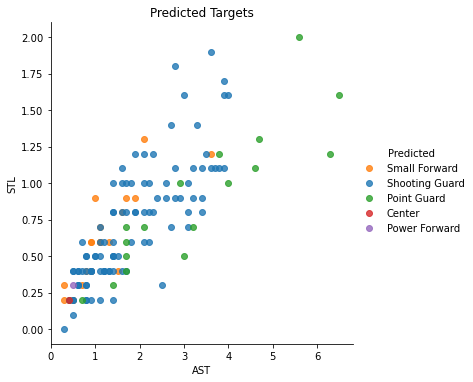

In [30]:
seaborn.lmplot(x='AST',y='STL', data=just_sg,hue='Predicted', fit_reg =False,palette=['#ff7f0e','#1f77b4','#2ca02c','#d62728','#9467bd'])
plt.title('Predicted Targets');


Points were pretty high up on the gini importance - given that there are different types of field goals that can be made (2 points/3 points) it might be informative to add in the different field goal attempts. Since the big guys typically play more in the paint and the vs the smaller guys play around the perimeter. However, we do need to keep in mind that the idea of that the league didn't adopt the 3-pointer until 1979--Magic Johnson and Larry Bird's rookie season.

### Add in 3PA and 2PAs

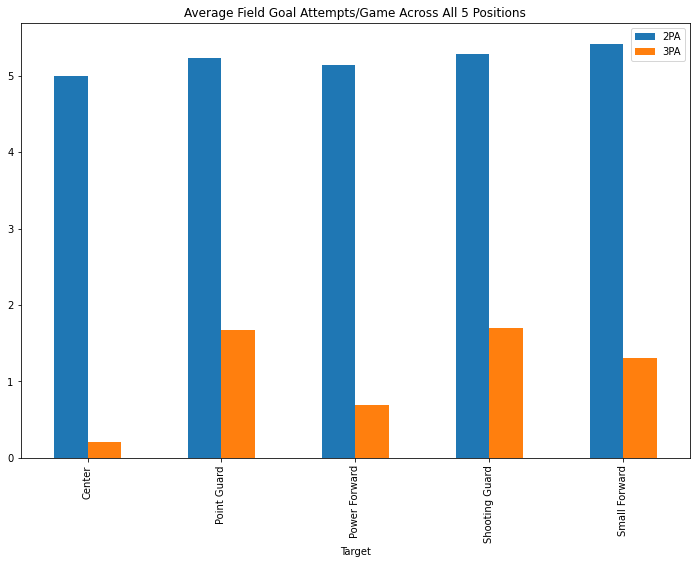

In [31]:
field_goals = summary[['2PA', '3PA']]
field_goals.plot(kind='bar', figsize = (12, 8))
plt.title('Average Field Goal Attempts/Game Across All 5 Positions');

Not a huge disparity between 2PAs across the 5 positions unlike 3PAs, which might be more telling. Assuming NaNs are of players from prior to 1979 before the adoption of 3 pointers - changing the NaNs to 0. 

train accuracy: 0.6262222222222221 | test accuracy: 0.6358792184724689


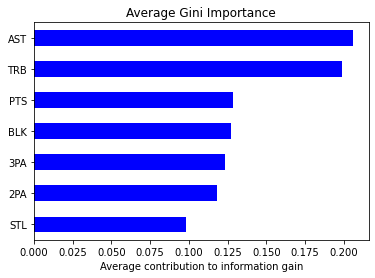

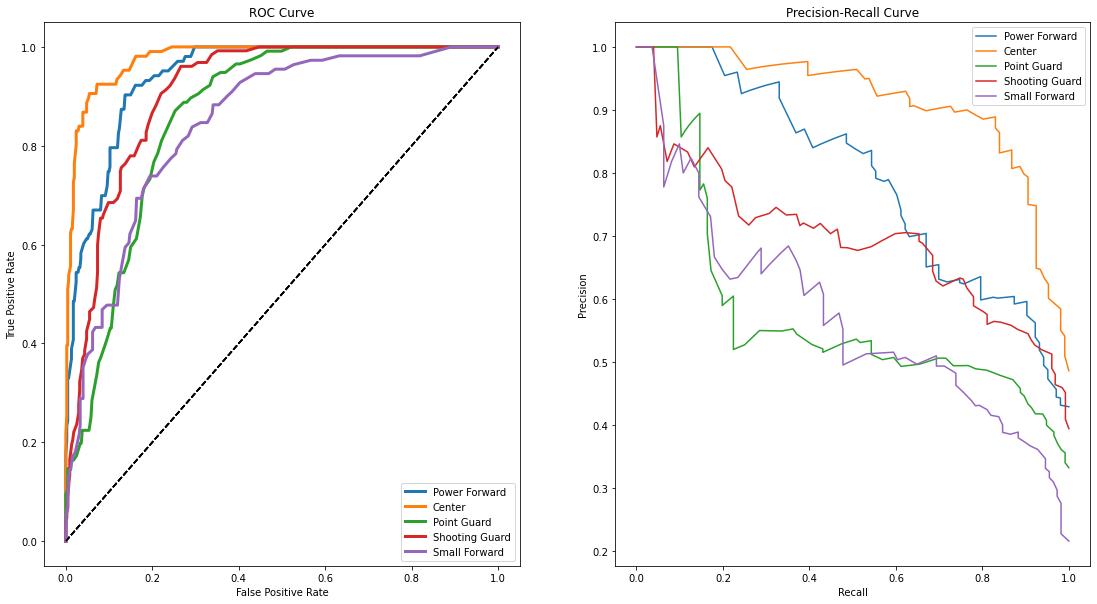

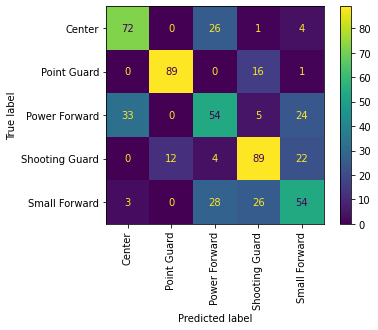

In [32]:
df = all_player_stats.copy()
df['3PA'].replace({np.NaN: 0}, inplace = True)
model_features = ['PTS', 'TRB', 'AST', 'STL', 'BLK','2PA','3PA']
random_forest(df,model_features)

### Dropping nans instead of changing 3PA to 0s

train accuracy: 0.641255605381166 | test accuracy: 0.6182795698924731


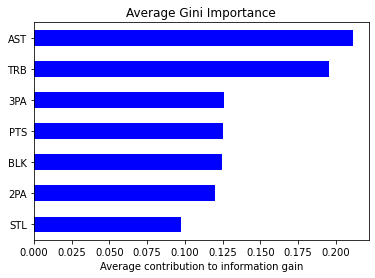

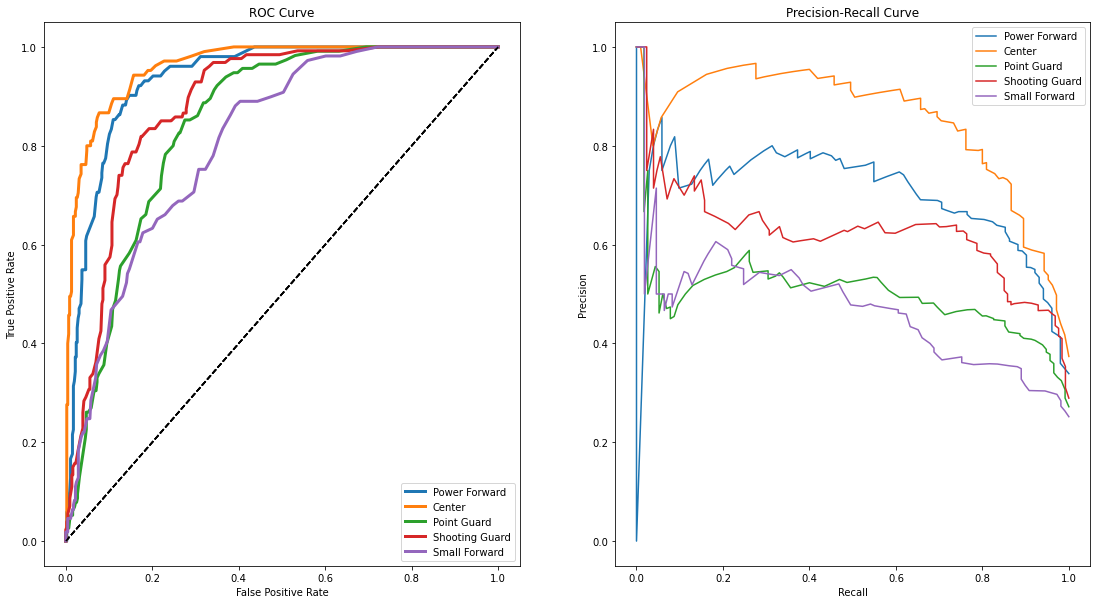

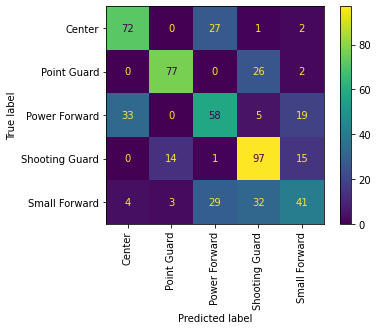

In [33]:
model_features = ['PTS', 'TRB', 'AST', 'STL', 'BLK','2PA','3PA']
random_forest(all_player_stats,model_features)

### All Targets
Haven't tried predicting on all targets yet - let's try and compare and get the gini importance. Use standard scaler because some metrics are percentages and will be on different scales

train accuracy: 0.6375 | test accuracy: 0.614


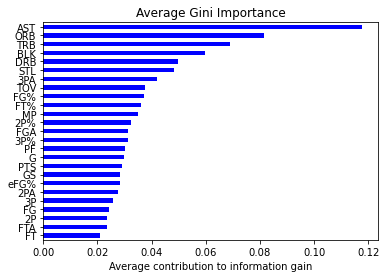

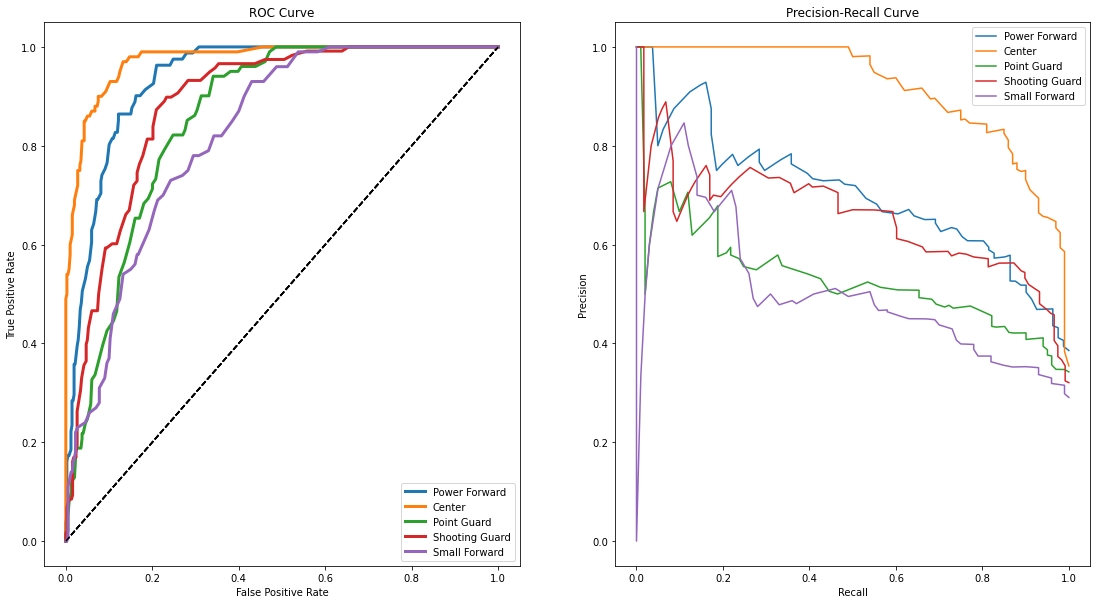

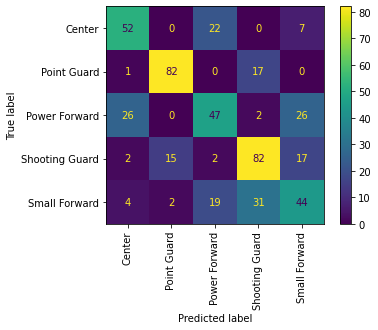

In [34]:
model_features = ['G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA',
       '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB',
       'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS']
random_forest(all_player_stats,model_features)

### Top Seven Gini Importance

train accuracy: 0.6260089686098654 | test accuracy: 0.5913978494623656


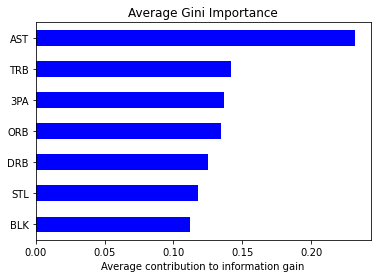

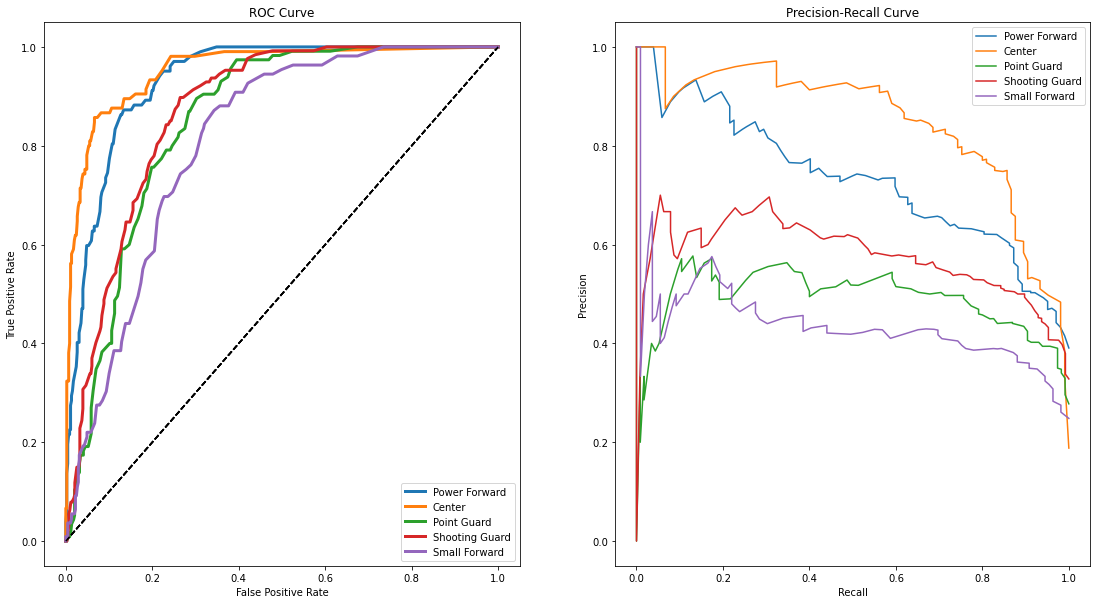

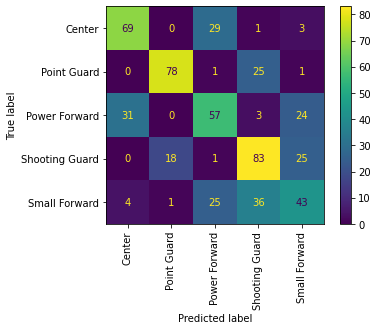

In [35]:
model_features = ['AST','ORB','TRB','BLK','DRB','STL','3PA']
random_forest(all_player_stats,model_features)

## Logistic Regression

In [36]:
def log_reg(df,model_features,drop_na=True,confusion_matrix = True,roc=True):
    
    
    if drop_na == True:
        total_features = model_features + ['Target']
        df = df[total_features].dropna(axis=0)
        X = df[model_features]
        y = df['Target']
    else:
        X = df[model_features]
        y = df['Target']
    
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.20, random_state = 23, stratify = y)

    
    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    
    X_train = pd.DataFrame(data=X_train, columns = X.columns)
    X_test = pd.DataFrame(data=X_test, columns = X.columns)
    
    lr = LogisticRegression(max_iter=400).fit(X_train,y_train)
    
    print(f'train accuracy: {cross_val_score(lr,X_train,y_train,cv=5).mean()} | test accuracy: {lr.score(X_test,y_test)}')
    
    
    if roc == True: 
        predicted_prob = lr.predict_proba(X_test)
        fig, axs = plt.subplots(1,2, figsize=(18.75,10))
        y_test_dummy = pd.get_dummies(y_test).values
        labels = ['Power Forward', 'Center', 'Point Guard', 'Shooting Guard',
           'Small Forward']
        for i in range(5):
            # ROC Curve
            fpr,tpr,thresholds = roc_curve(y_test_dummy[:,i],predicted_prob[:,i])
            axs[0].plot(fpr,tpr,lw=3,label=labels[i])#,color=colors[i])
            axs[0].plot([0,1],[0,1],color='k',ls='--')
            axs[0].set_xlabel('False Positive Rate')
            axs[0].set_ylabel('True Positive Rate')
            axs[0].legend()
            axs[0].set_title('ROC Curve')
            # Precision-Recall Curve
            precision,recall,thresholds = precision_recall_curve(y_test_dummy[:,i],predicted_prob[:,i])
            axs[1].plot(recall,precision,label=labels[i])#,color=colors[i])
            axs[1].set_xlabel('Recall')
            axs[1].set_ylabel('Precision')
            axs[1].set_title('Precision-Recall Curve')
            axs[1].legend() 
    
    if confusion_matrix == True:
        plot_confusion_matrix(lr,X_test,y_test,xticks_rotation='vertical');

Try the same thing as what we did with rf but with logistic regression

### 5 Main Stats

train accuracy: 0.6612844994267919 | test accuracy: 0.6760330578512397


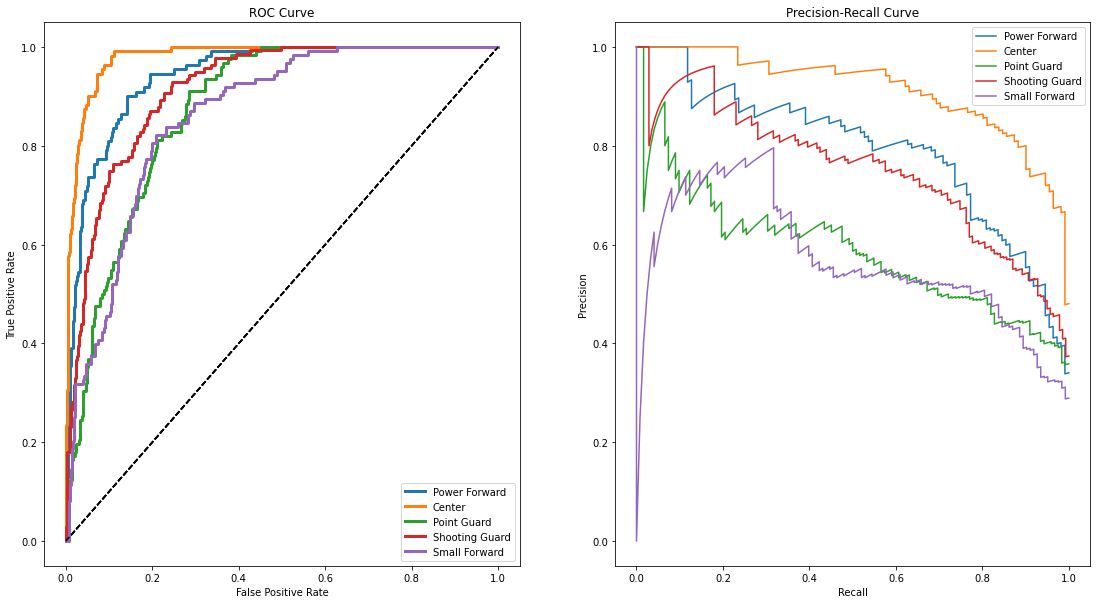

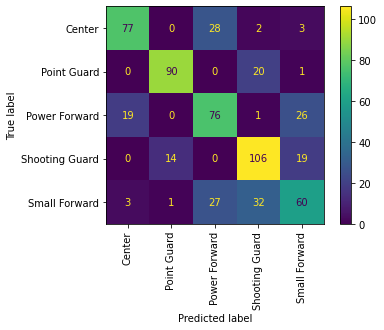

In [37]:
model_features = ['PTS', 'TRB', 'AST', 'STL', 'BLK']
log_reg(all_player_stats,model_features)

### Add in 3PA and 2PAs

train accuracy: 0.6693333333333333 | test accuracy: 0.6838365896980462


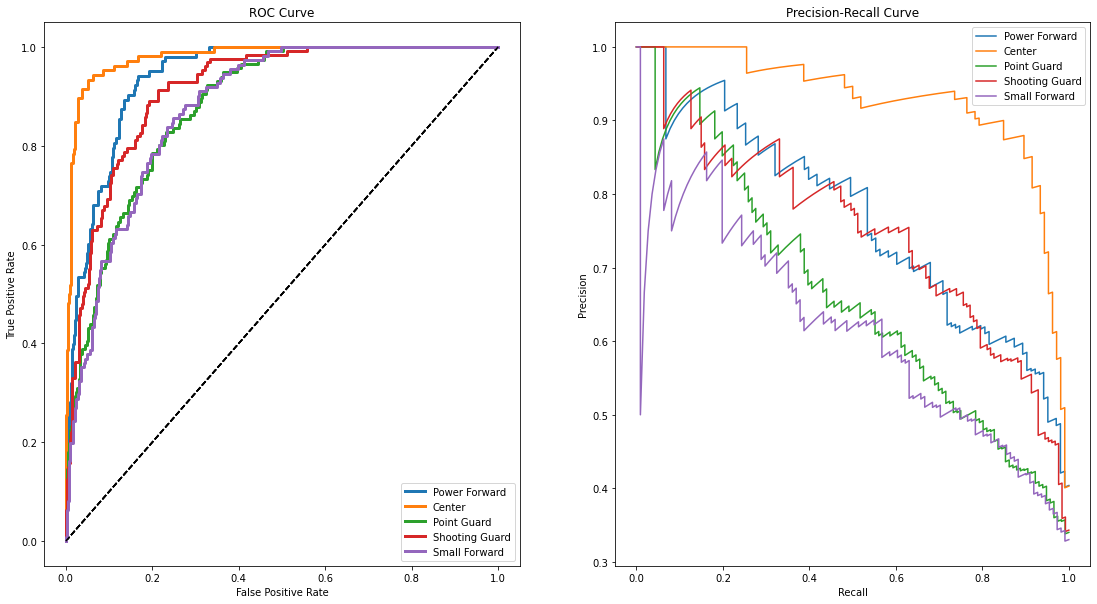

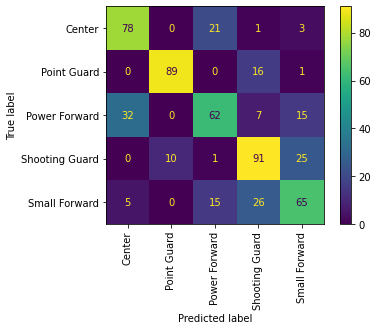

In [38]:
df = all_player_stats.copy()
df['3PA'].replace({np.NaN: 0}, inplace = True)
model_features = ['PTS', 'TRB', 'AST', 'STL', 'BLK','2PA','3PA']
log_reg(df,model_features)

### Dropping nans instead of changing 3PA to 0s

train accuracy: 0.6757847533632286 | test accuracy: 0.6612903225806451


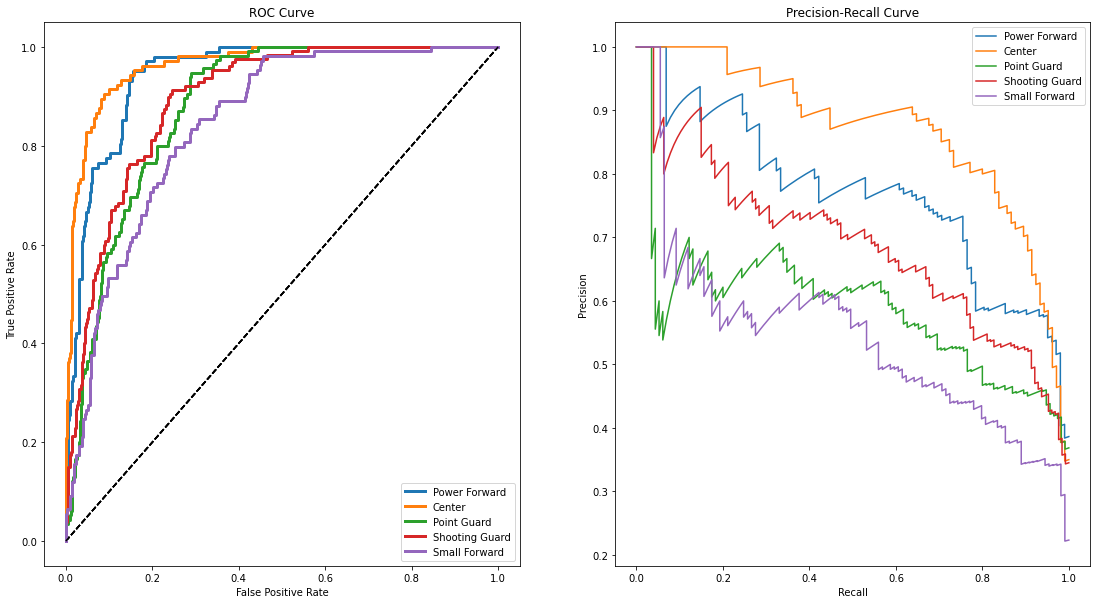

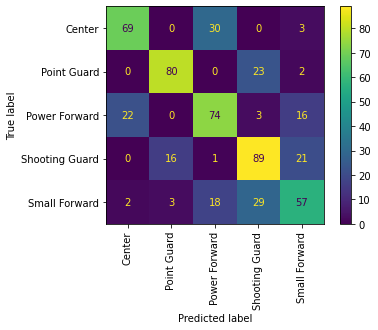

In [39]:
model_features = ['PTS', 'TRB', 'AST', 'STL', 'BLK','2PA','3PA']
log_reg(all_player_stats,model_features)

### All Targets

train accuracy: 0.6839999999999999 | test accuracy: 0.654


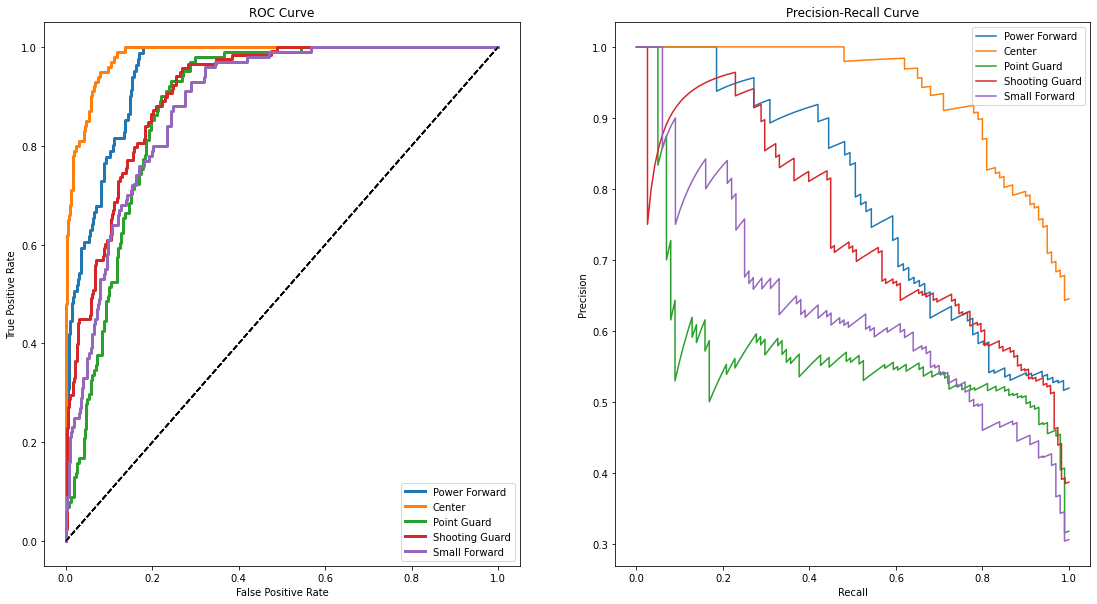

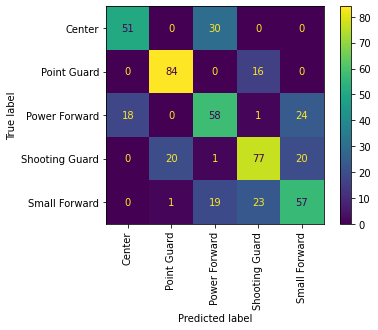

In [40]:
model_features = ['G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA',
       '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB',
       'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS']
log_reg(all_player_stats,model_features)

### Top Seven Gini Importance

train accuracy: 0.648878923766816 | test accuracy: 0.6290322580645161


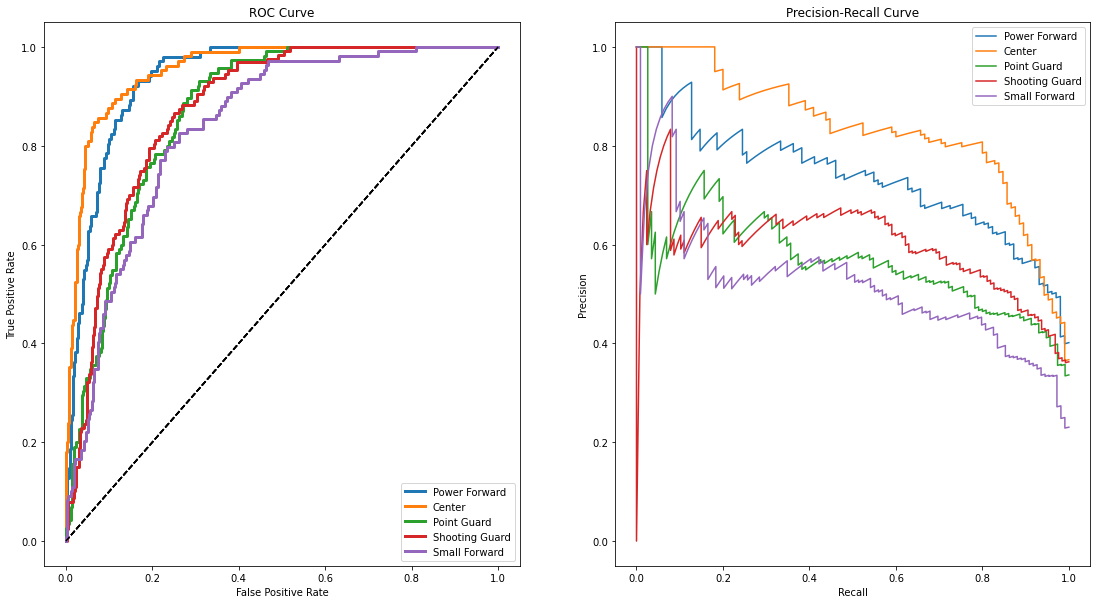

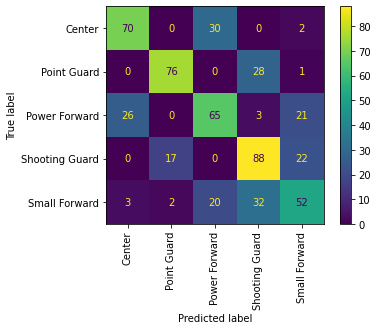

In [41]:
model_features = ['AST','ORB','TRB','BLK','DRB','STL','3PA']
log_reg(all_player_stats,model_features)

### Addressing Missing Values

Seems like logistic regression is perfoming the best so far - currently we are just dropping rows with NaN values but we don't have much data to begin with - so lets try imputing with KNN

In [43]:
def missing_values_percent(df):
    
    for feature in df.columns:
        # count number of rows with missing values
        n_miss = df[feature].isnull().sum()
        perc = n_miss / df.shape[0] * 100
        print(f'{feature}, Missing: {n_miss} ({perc})')

In [44]:
missing_values_percent(all_player_stats)

Player, Missing: 0 (0.0)
Pos, Missing: 0 (0.0)
G, Missing: 0 (0.0)
GS, Missing: 931 (25.940373363053777)
MP, Missing: 77 (2.145444413485651)
FG, Missing: 0 (0.0)
FGA, Missing: 0 (0.0)
FG%, Missing: 0 (0.0)
3P, Missing: 768 (21.3987183059348)
3PA, Missing: 768 (21.3987183059348)
3P%, Missing: 952 (26.525494566731677)
2P, Missing: 692 (19.281136806910002)
2PA, Missing: 692 (19.281136806910002)
2P%, Missing: 692 (19.281136806910002)
eFG%, Missing: 692 (19.281136806910002)
FT, Missing: 0 (0.0)
FTA, Missing: 0 (0.0)
FT%, Missing: 3 (0.08358874338255781)
ORB, Missing: 538 (14.990247979938701)
DRB, Missing: 538 (14.990247979938701)
TRB, Missing: 56 (1.560323209807746)
AST, Missing: 0 (0.0)
STL, Missing: 566 (15.770409584842573)
BLK, Missing: 566 (15.770409584842573)
TOV, Missing: 690 (19.225410977988297)
PF, Missing: 0 (0.0)
PTS, Missing: 0 (0.0)
Target, Missing: 0 (0.0)
Num_Pos, Missing: 0 (0.0)


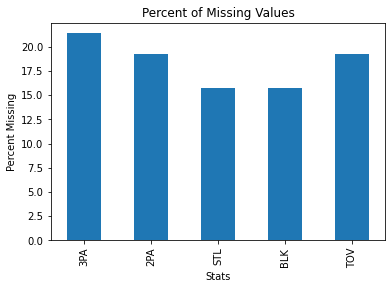

In [45]:
plot_percent_missing = pd.DataFrame({"Stats": [21.3987183059348,19.281136806910002,15.770409584842573,15.770409584842573,19.225410977988297]},index = ['3PA','2PA','STL','BLK','TOV'])

plot_percent_missing.plot(kind='bar',legend=False)
plt.xlabel('Stats')
plt.ylabel('Percent Missing')
plt.title('Percent of Missing Values');

Looking at one specific feature

In [46]:
all_player_stats[all_player_stats['2PA'].isnull()]

Player                              Pos      G  GS    MP  \
1       Zaid Abdul-Aziz         Center and Power Forward  505.0 NaN  21.8   
11         Don Ackerman                      Point Guard   28.0 NaN   7.9   
13            Bud Acton                    Small Forward   23.0 NaN   8.5   
25         Rick Adelman                      Point Guard  462.0 NaN  22.6   
38          Gary Alcorn                           Center   78.0 NaN  10.8   
...                 ...                              ...    ...  ..   ...   
4472  Charlie Yelverton                   Shooting Guard   69.0 NaN  17.8   
4486      Max Zaslofsky                   Shooting Guard  373.0 NaN  28.3   
4487       Zeke Zawoluk  Power Forward and Small Forward  179.0 NaN  19.7   
4489        Dave Zeller                      Point Guard   61.0 NaN   4.6   
4502          Bill Zopf                      Point Guard   53.0 NaN   7.5   

       FG   FGA    FG%  3P  3PA  ...  DRB  TRB  AST  STL  BLK  TOV   PF   PTS  \
1     3.5   8.2  0.428 NaN  NaN  ...  5.4  8.0  1.2  0.6  1.0  0.9  2.2   9.0   
11    0.5   2.3  0.222 NaN  NaN  ...  NaN  0.5  0.8  NaN  NaN  NaN  1.5   1.5   
13    1.3   3.2  0.392 NaN  NaN  ...  NaN  2.0  0.5  NaN  NaN  NaN  1.5   3.3   
25    3.0   7.2  0.415 NaN  NaN  ...  1.1  2.4  3.5  0.9  0.1  NaN  2.1   7.7   
38    1.3   4.5  0.293 NaN  NaN  ...  NaN  4.2  0.3  NaN  NaN  NaN  2.2   3.3   
...   ...   ...    ...  ..  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   
4472  3.0   7.7  0.389 NaN  NaN  ...  NaN  2.9  1.2  NaN  NaN  NaN  2.1   7.9   
4486  4.6  13.2  0.350 NaN  NaN  ...  NaN  2.8  2.3  NaN  NaN  NaN  2.4  13.2   
4487  2.2   5.9  0.372 NaN  NaN  ...  NaN  4.1  1.2  NaN  NaN  NaN  2.5   6.8   
4489  0.6   1.7  0.353 NaN  NaN  ...  NaN  0.4  1.0  NaN  NaN  NaN  0.6   1.5   
4502  0.9   2.5  0.363 NaN  NaN  ...  NaN  0.9  1.4  NaN  NaN  NaN  0.6   2.2   

              Target  Num_Pos  
1             Center        1  
11       Point Guard        0  
13     Small Forward        0  
25       Point Guard        0  
38            Center        0  
...              ...      ...  
4472  Shooting Guard        0  
4486  Shooting Guard        0  
4487   Power Forward        1  
4489     Point Guard        0  
4502     Point Guard        0  

[692 rows x 29 columns]

When scraping the data - I knew there would be NaNs since some stats were not available for some players (it seems like it mostly was for the earlier seasons in the NBA) - we don't have dates for the data so I cannot filter it out by date. And other NaNs make sense i.e. why some players have NaNs for 3 point attempts since 3 pointers weren't a thing prior to 1979 but looking at some examples where 2 point attempts were NaNs we can see that field goal attempts were not - that means those player simply just didn't have field goal attempt break downs (goes back to the first point). 

In [51]:
def roc(model, X_test, y_test):

    Predicted_prob = model.predict_proba(X_test)
    fig, axs = plt.subplots(1,2, figsize=(18.75,10))
    y_test_dummy = pd.get_dummies(y_test).values
    labels = ['Power Forward', 'Center', 'Point Guard', 'Shooting Guard',
       'Small Forward']
    for i in range(5):
        # ROC Curve
        fpr,tpr,thresholds = roc_curve(y_test_dummy[:,i],Predicted_prob[:,i])
        axs[0].plot(fpr,tpr,lw=3,label=labels[i])#,color=colors[i])
        axs[0].plot([0,1],[0,1],color='k',ls='--')
        axs[0].set_xlabel('False Positive Rate')
        axs[0].set_ylabel('True Positive Rate')
        axs[0].legend()
        axs[0].set_title('ROC Curve')
        # Precision-Recall Curve
        precision,recall,thresholds = precision_recall_curve(y_test_dummy[:,i],Predicted_prob[:,i])
        axs[1].plot(recall,precision,label=labels[i])#,color=colors[i])
        axs[1].set_xlabel('Recall')
        axs[1].set_ylabel('Precision')
        axs[1].set_title('Precision-Recall Curve')
        axs[1].legend() 

In [65]:
def pick_k_rf(X,y,n,model_features):
    
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.20, random_state = 23, stratify = y)
    
    scaler = StandardScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    imputer = KNNImputer(n_neighbors=n).fit(X_train_scaled)
    X_train_scaled_imputed = imputer.transform(X_train_scaled)
    X_test_scaled_imputed = imputer.transform(X_test_scaled)
    
    predicted_nans_X_train = pd.DataFrame(data=X_train_scaled_imputed, columns = X.columns)
    predicted_nans_X_test = pd.DataFrame(data=X_test_scaled_imputed, columns = X.columns)
    
    
    for n in range(1,n+1):
        imputer = KNNImputer(n_neighbors=n).fit(X_train_scaled)
        X_train_scaled_imputed = imputer.transform(X_train_scaled)
        X_test_scaled_imputed = imputer.transform(X_test_scaled)
    
        predicted_nans_X_train = pd.DataFrame(data=X_train_scaled_imputed, columns = X.columns)
        predicted_nans_X_test = pd.DataFrame(data=X_test_scaled_imputed, columns = X.columns)
        
        X_train_final = predicted_nans_X_train[model_features]
        X_test_final = predicted_nans_X_test[model_features]
        


        rf = RandomForestClassifier(max_depth= 15, max_features= 3, min_samples_leaf= 5, min_samples_split= 8, n_estimators= 100).fit(X_train_final,y_train)
        rf_predicted = rf.predict(X_test_final)

        print(f'train accuracy: {cross_val_score(rf,X_train_final,y_train,cv=5).mean()} | test accuracy cross val: {accuracy_score(y_test,rf_predicted)}');
        plot_confusion_matrix(rf,X_test_final,y_test,xticks_rotation='vertical')
        roc(rf, X_test_final, y_test)


In [64]:
def pick_k_lr(X,y,n,model_features):
    
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.20, random_state = 23, stratify = y)
    
    scaler = StandardScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    imputer = KNNImputer(n_neighbors=n).fit(X_train_scaled)
    X_train_scaled_imputed = imputer.transform(X_train_scaled)
    X_test_scaled_imputed = imputer.transform(X_test_scaled)
    
    predicted_nans_X_train = pd.DataFrame(data=X_train_scaled_imputed, columns = X.columns)
    predicted_nans_X_test = pd.DataFrame(data=X_test_scaled_imputed, columns = X.columns)
    
    
    for n in range(1,n+1):
        imputer = KNNImputer(n_neighbors=n).fit(X_train_scaled)
        X_train_scaled_imputed = imputer.transform(X_train_scaled)
        X_test_scaled_imputed = imputer.transform(X_test_scaled)
    
        predicted_nans_X_train = pd.DataFrame(data=X_train_scaled_imputed, columns = X.columns)
        predicted_nans_X_test = pd.DataFrame(data=X_test_scaled_imputed, columns = X.columns)
        
        X_train_final = predicted_nans_X_train[model_features]
        X_test_final = predicted_nans_X_test[model_features]
        


        lr = LogisticRegression(max_iter = 200, C=100).fit(X_train_final,y_train)
        lr_predicted = lr.predict(X_test_final)

        print(f'train accuracy: {cross_val_score(lr,X_train_final,y_train,cv=5).mean()} | test accuracy cross val: {accuracy_score(y_test,lr_predicted)}');
        plot_confusion_matrix(lr,X_test_final,y_test,xticks_rotation='vertical')
        roc(lr, X_test_final, y_test)

### Random Forest - KNN Imputer

train accuracy: 0.6189444023632783 | test accuracy cross val: 0.6114206128133705
train accuracy: 0.6196436903499469 | test accuracy cross val: 0.6253481894150418
train accuracy: 0.6227741251325558 | test accuracy cross val: 0.6155988857938719
train accuracy: 0.6252143614603847 | test accuracy cross val: 0.6253481894150418
train accuracy: 0.6252167853355552 | test accuracy cross val: 0.6337047353760445
train accuracy: 0.6210349946977731 | test accuracy cross val: 0.6323119777158774
train accuracy: 0.6290452961672475 | test accuracy cross val: 0.6155988857938719
train accuracy: 0.6287004999242539 | test accuracy cross val: 0.6239554317548747
train accuracy: 0.6307929101651265 | test accuracy cross val: 0.616991643454039
train accuracy: 0.6224287229207696 | test accuracy cross val: 0.6197771587743732


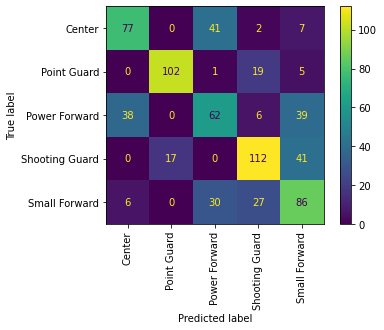

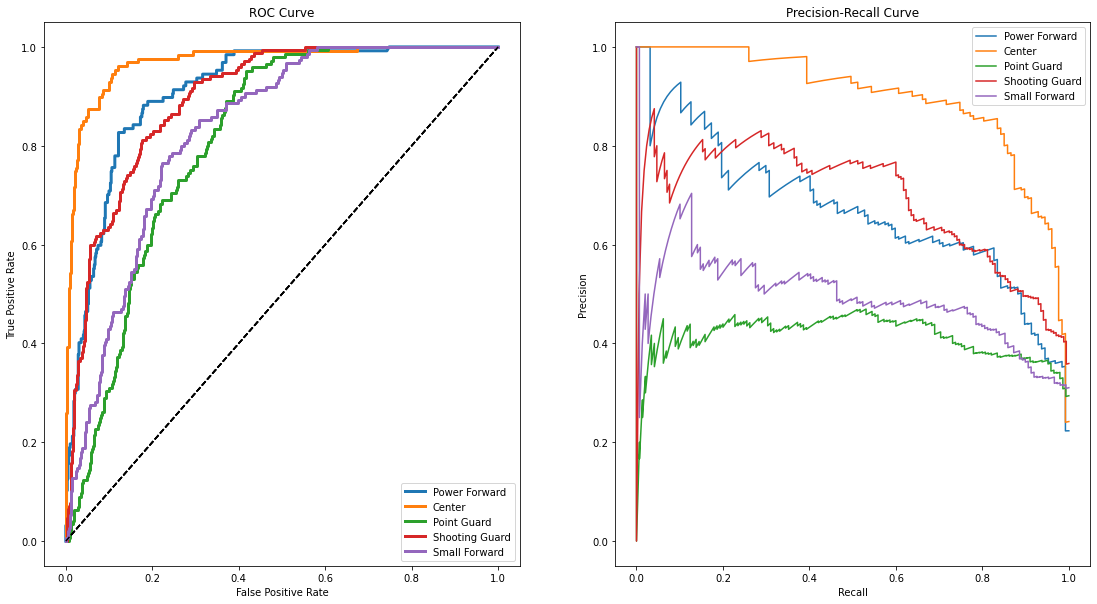

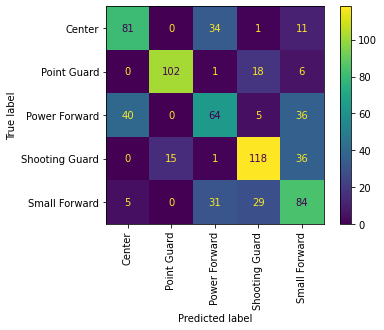

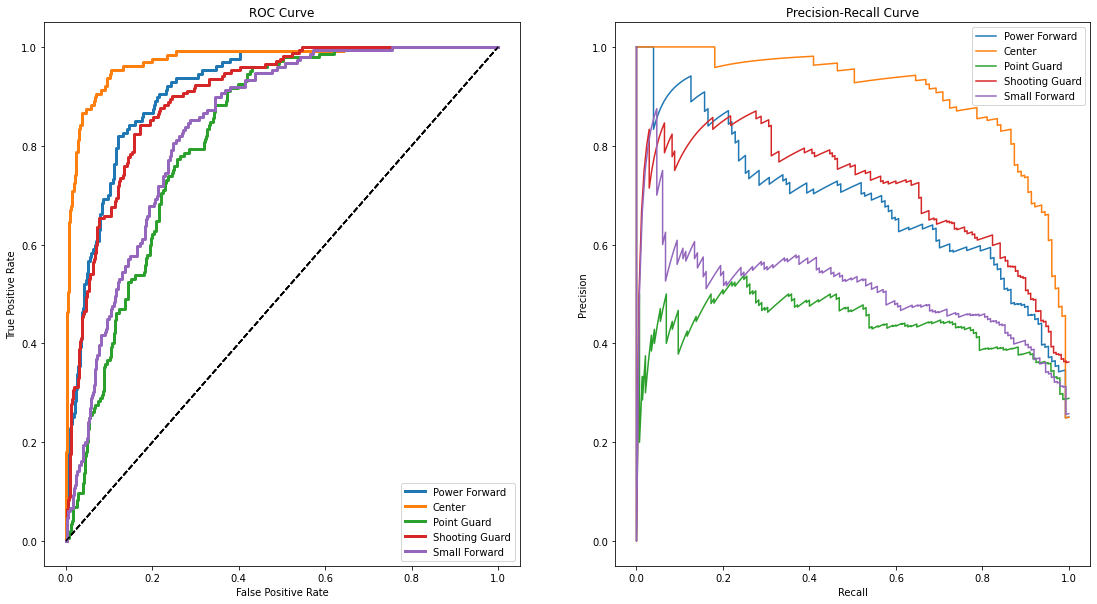

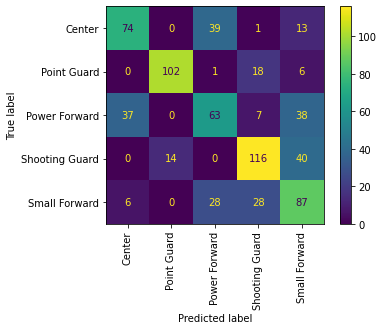

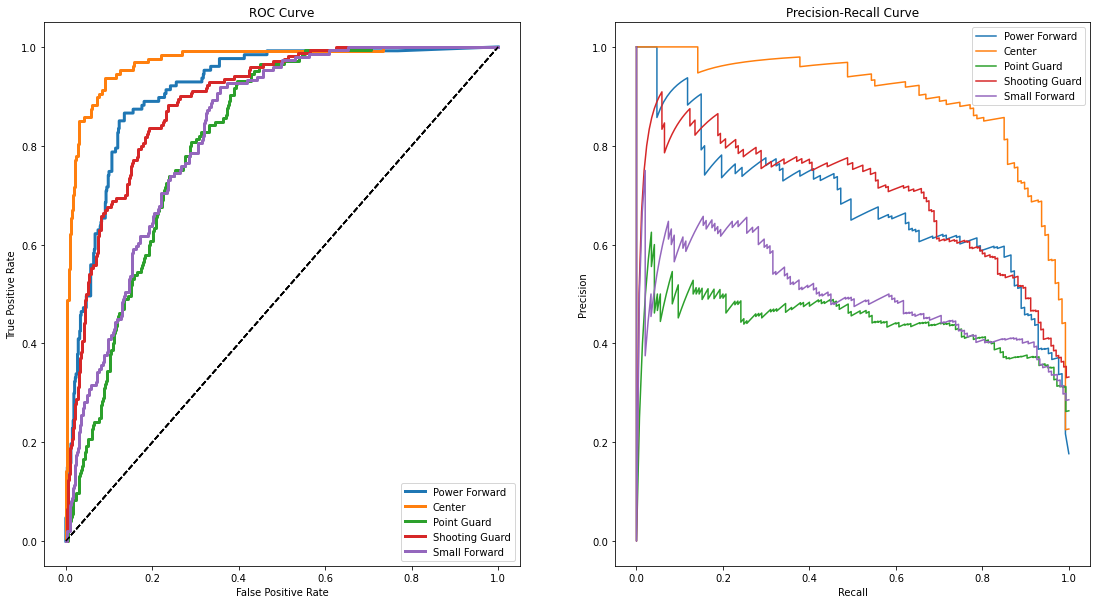

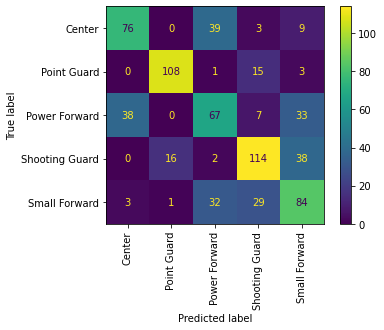

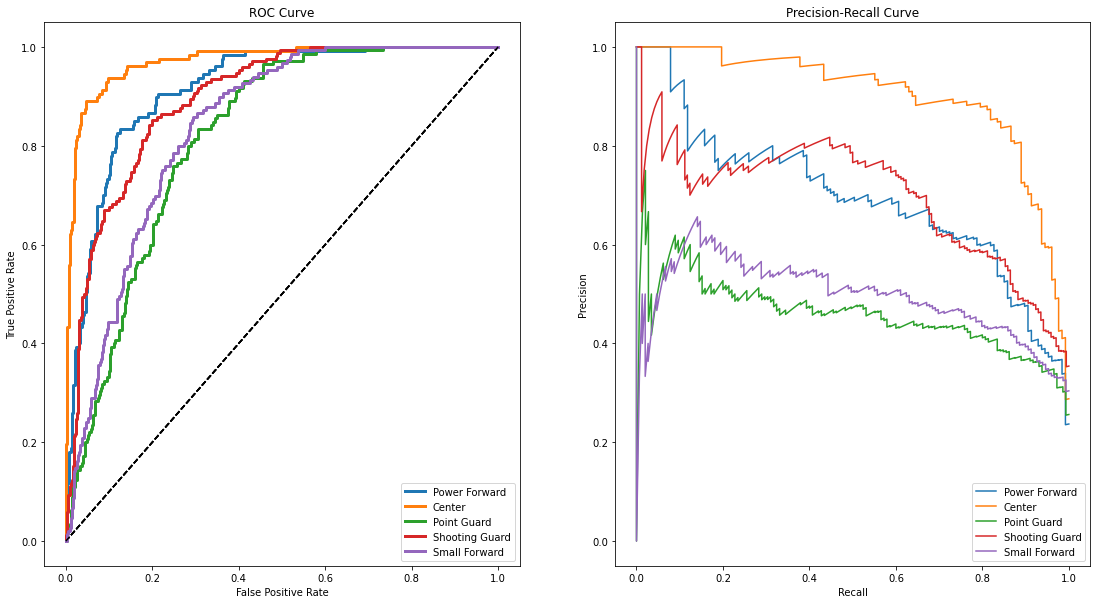

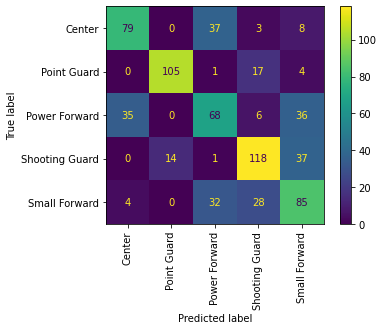

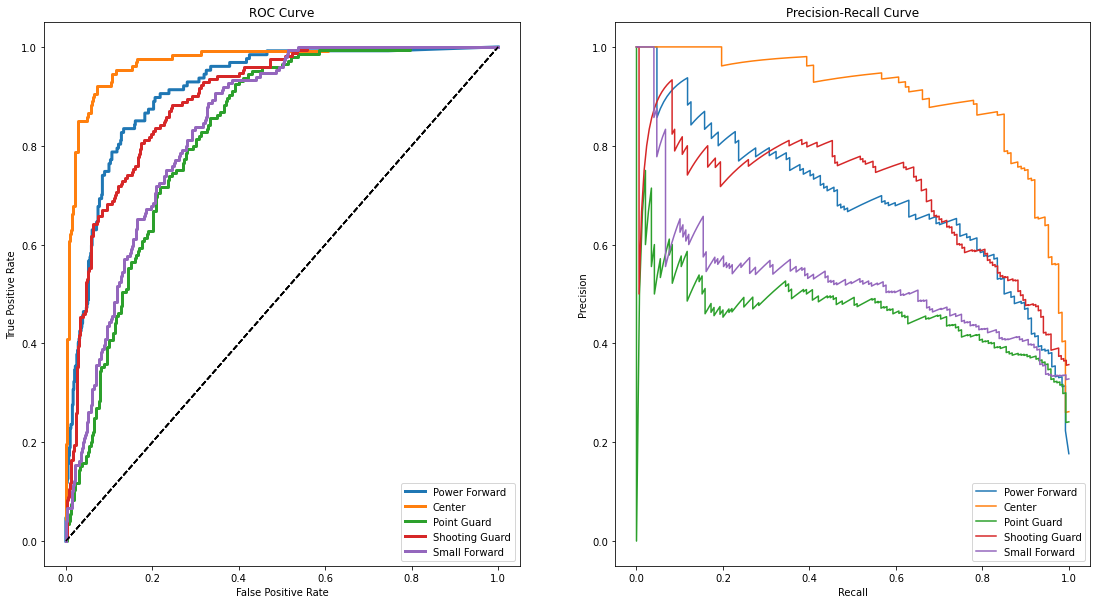

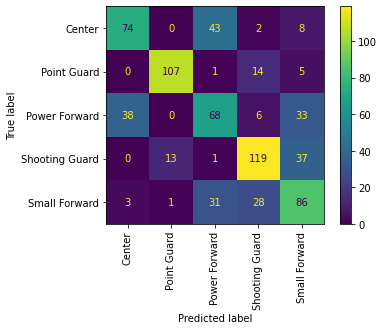

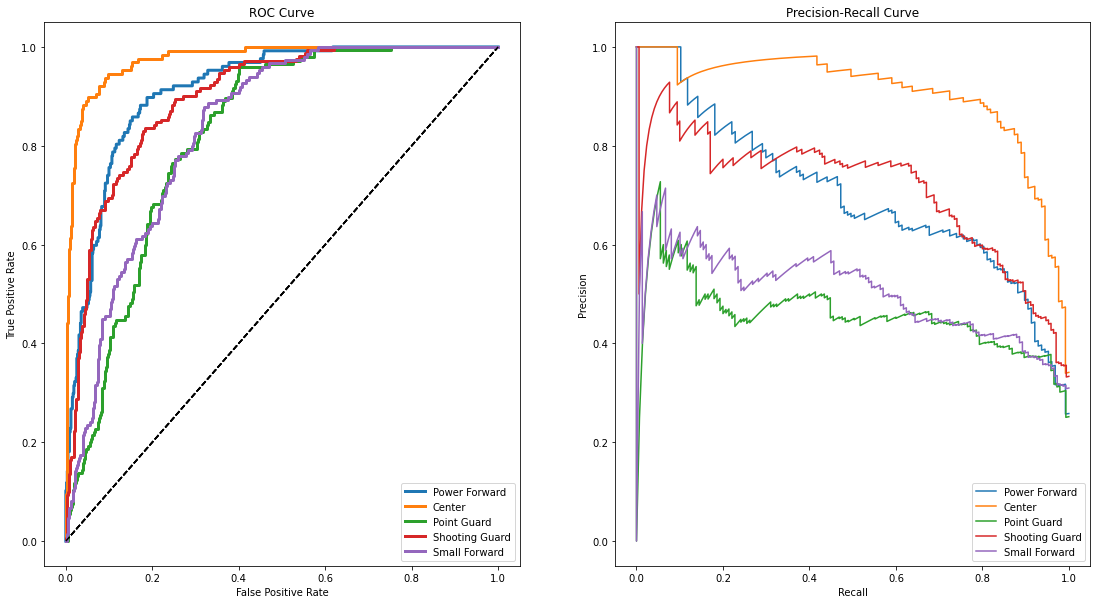

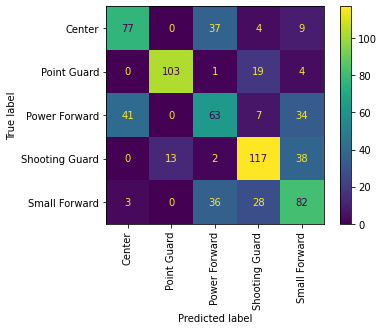

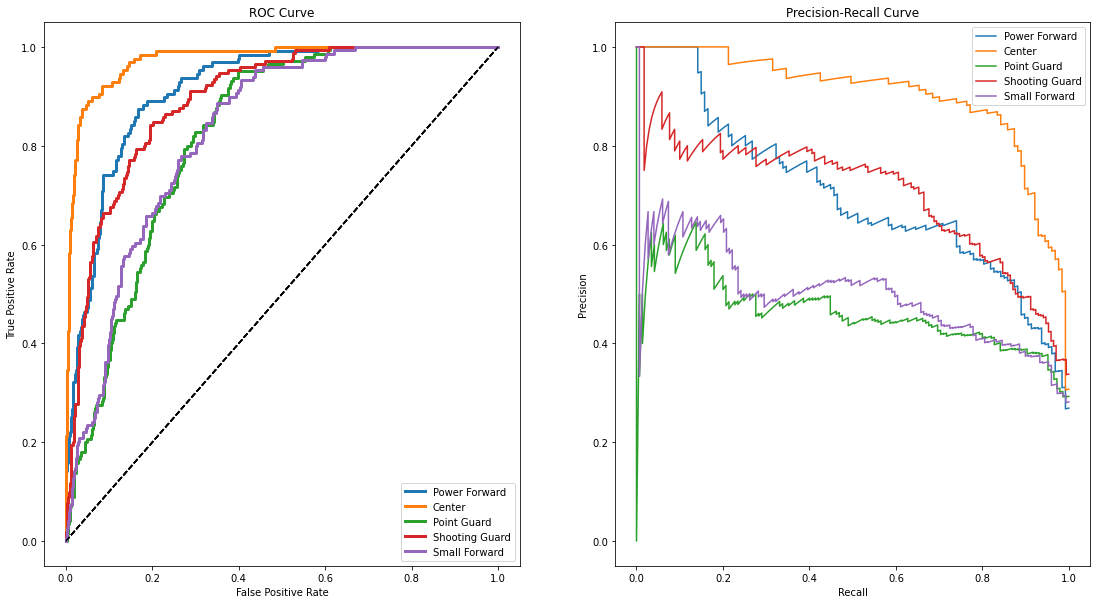

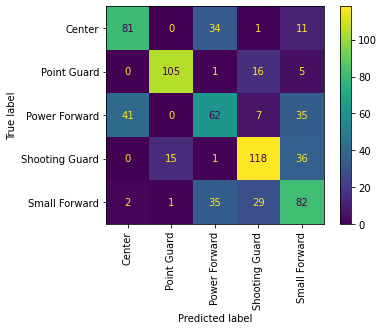

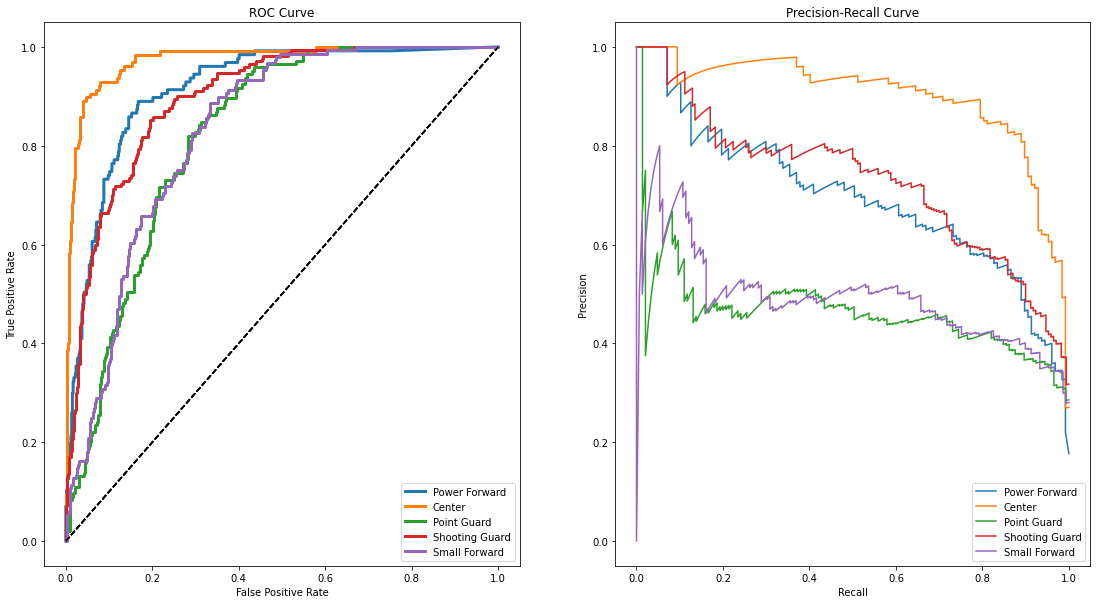

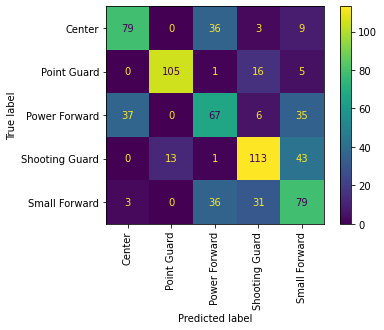

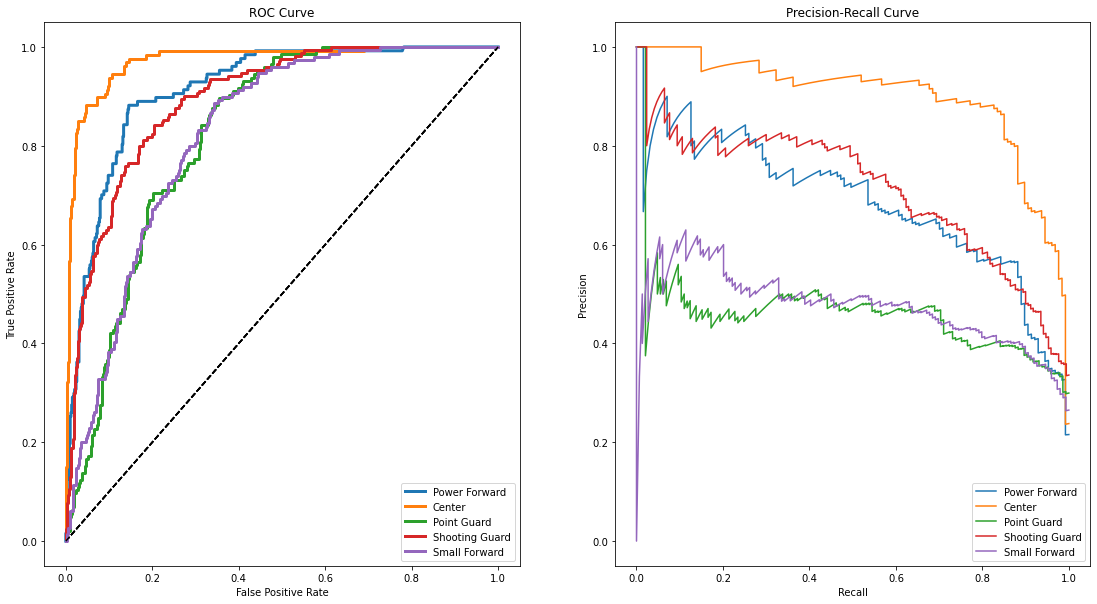

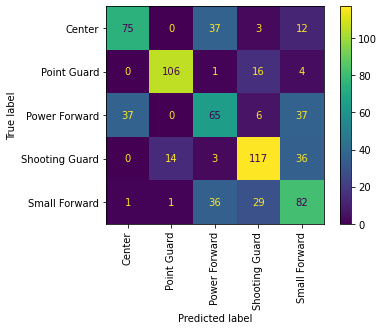

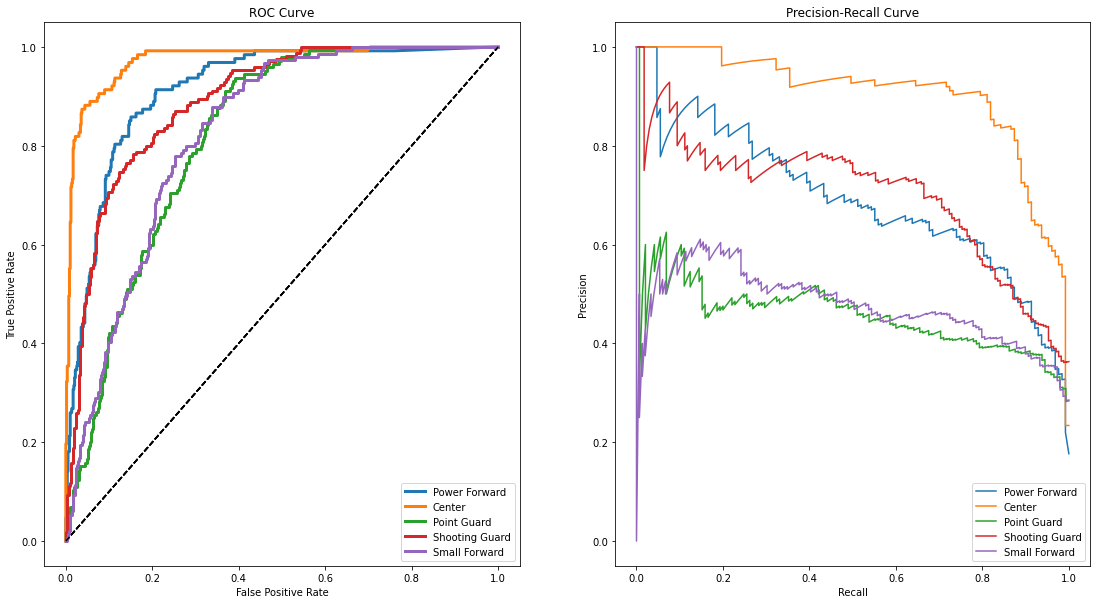

In [66]:
pick_k_rf(all_player_stats.drop(['Pos','Num_Pos','Target','Player'],axis=1),all_player_stats['Target'],10,['PTS', 'TRB', 'AST', 'STL', 'BLK','2PA','3PA'])

### Logistic Regression - KNN Imputer

train accuracy: 0.6321799727314044 | test accuracy cross val: 0.6239554317548747
train accuracy: 0.6335743069231935 | test accuracy cross val: 0.6337047353760445
train accuracy: 0.6335712770792303 | test accuracy cross val: 0.6350974930362117
train accuracy: 0.6346214209968186 | test accuracy cross val: 0.6420612813370473
train accuracy: 0.634272382972277 | test accuracy cross val: 0.6364902506963789
train accuracy: 0.6335737009544008 | test accuracy cross val: 0.6420612813370473
train accuracy: 0.6339209210725647 | test accuracy cross val: 0.6406685236768802
train accuracy: 0.6384481139221331 | test accuracy cross val: 0.6364902506963789
train accuracy: 0.637405241630056 | test accuracy cross val: 0.6392757660167131
train accuracy: 0.6363599454628086 | test accuracy cross val: 0.637883008356546


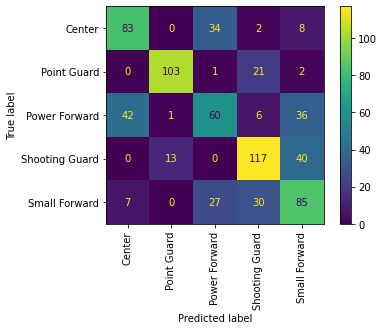

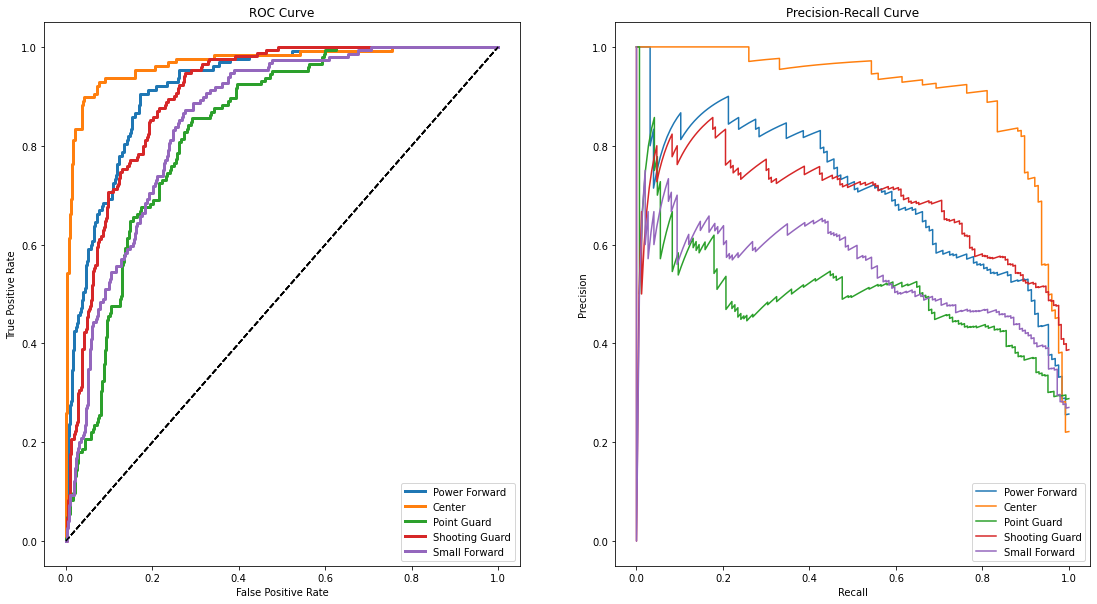

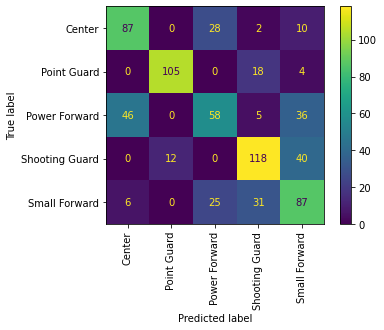

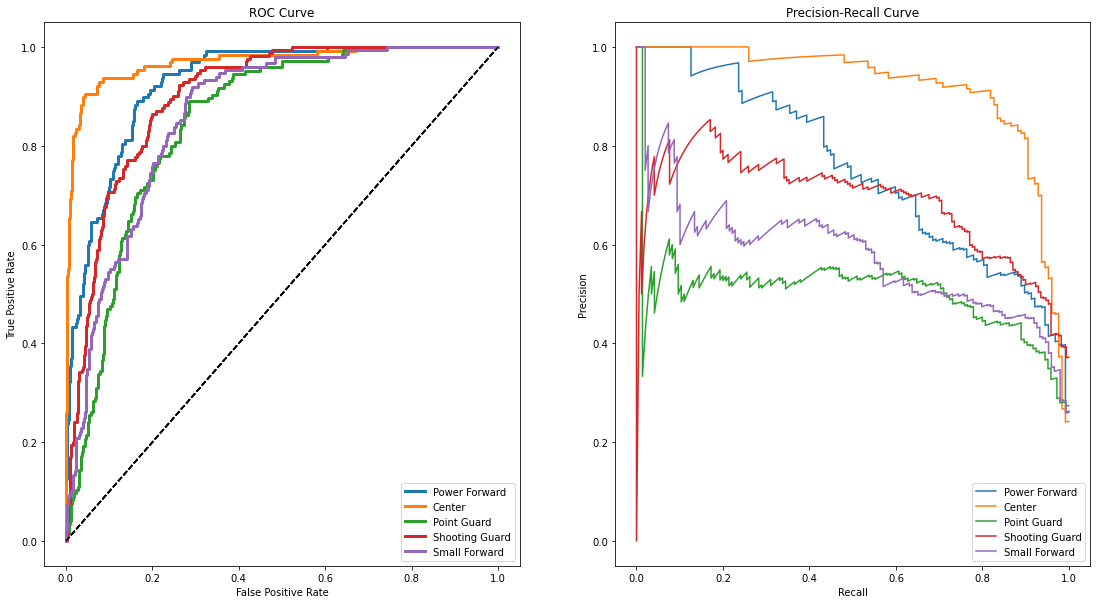

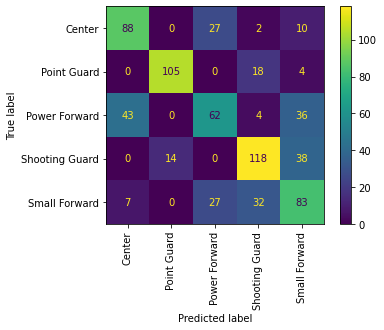

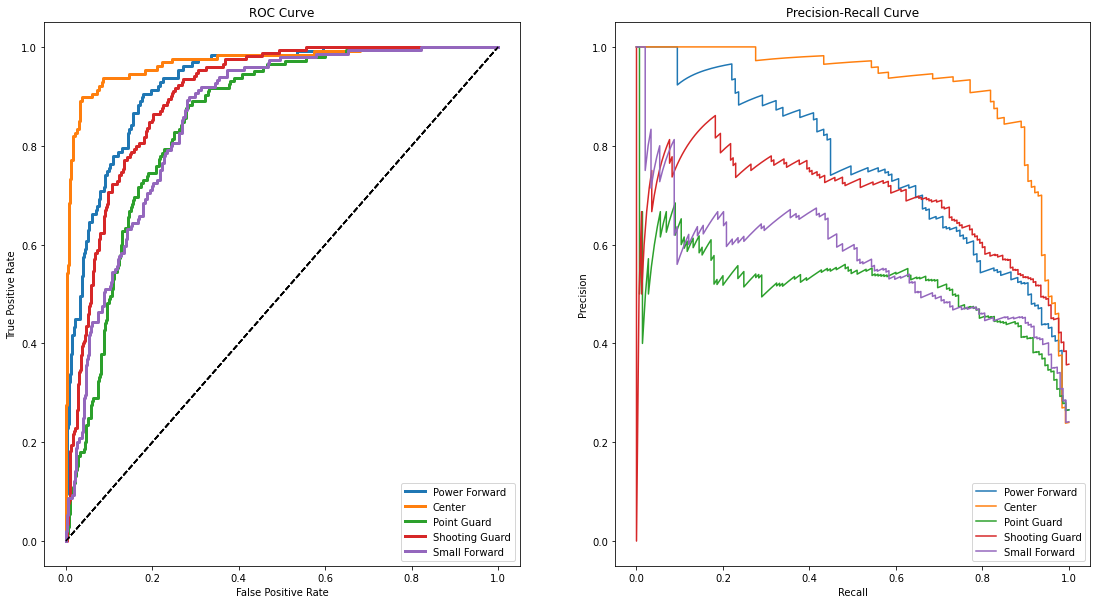

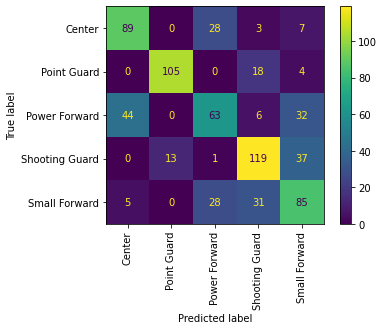

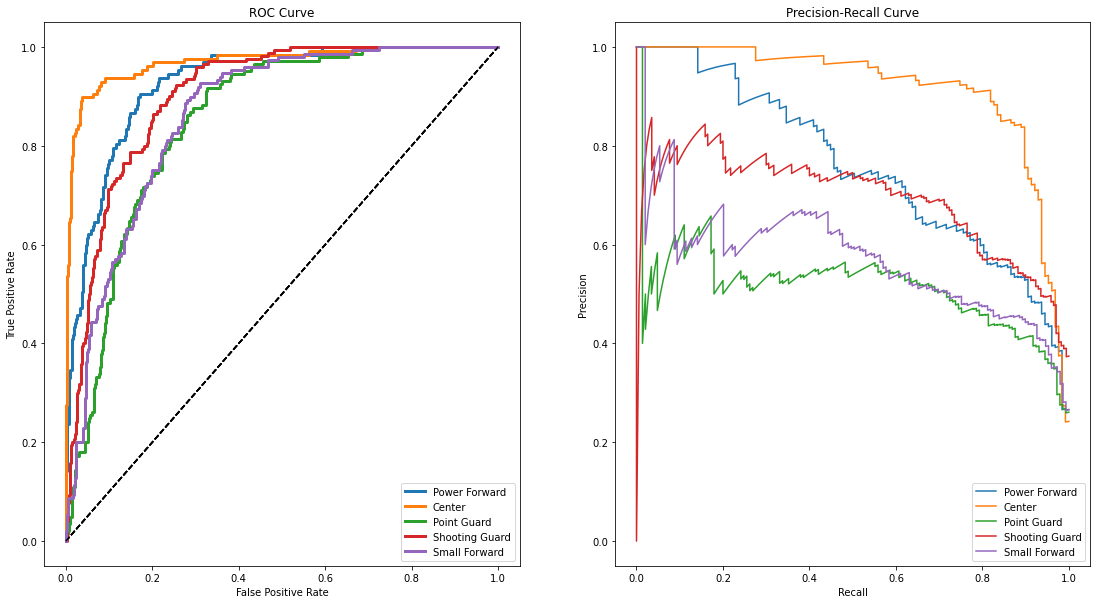

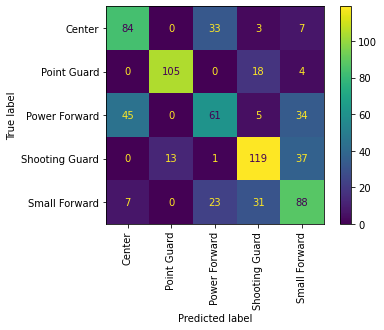

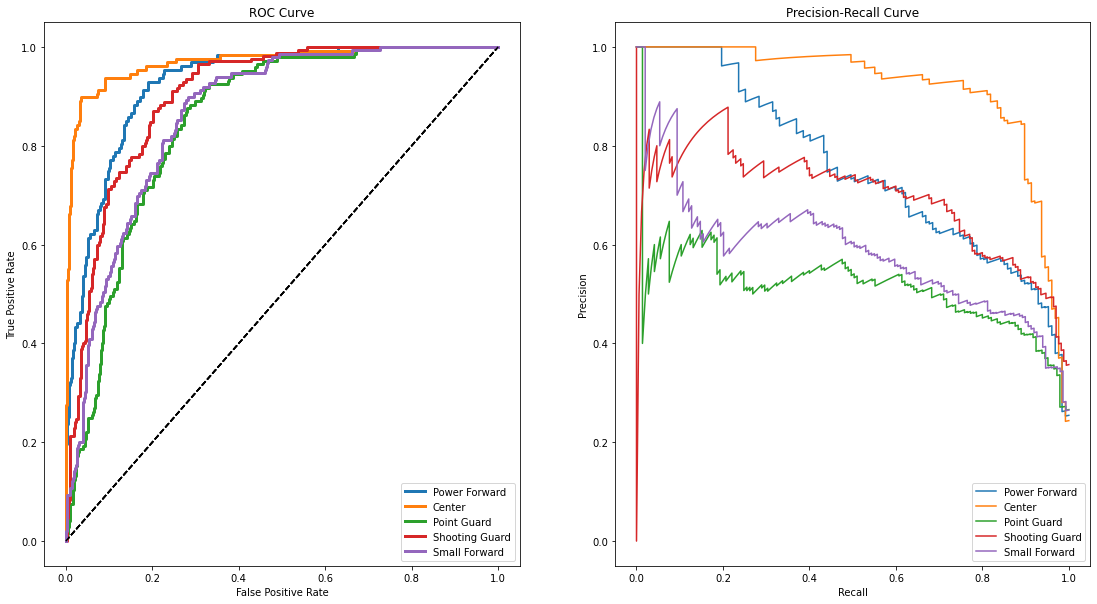

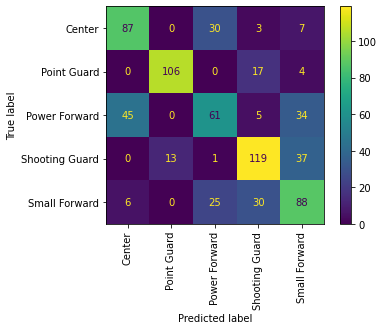

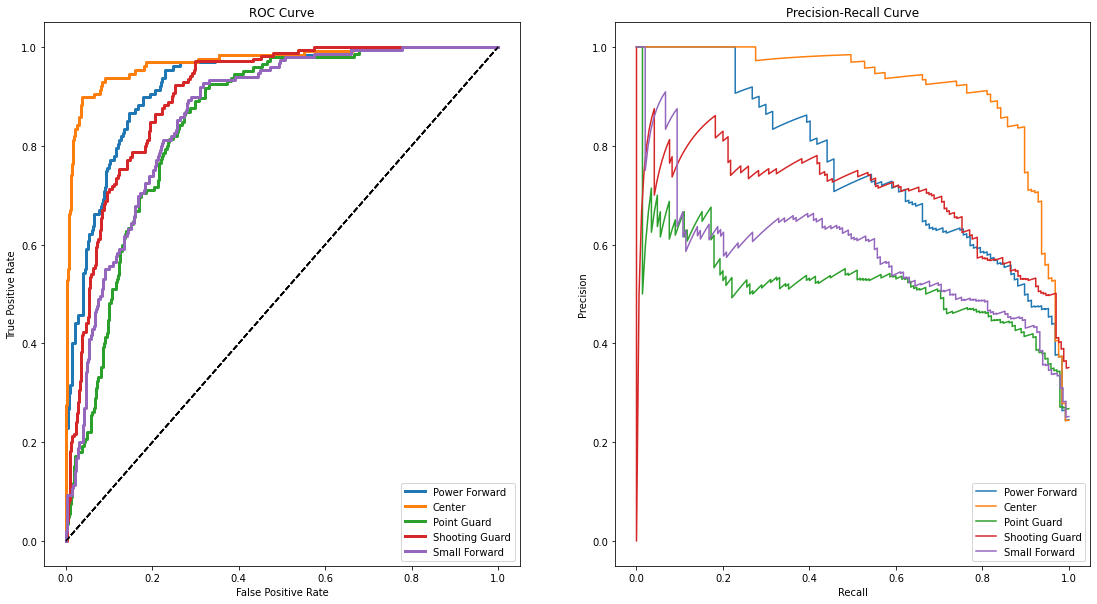

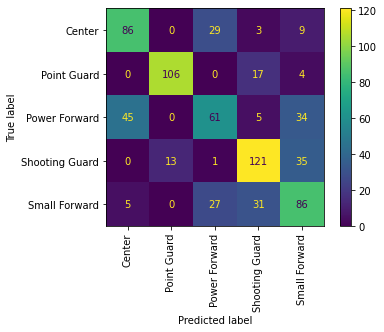

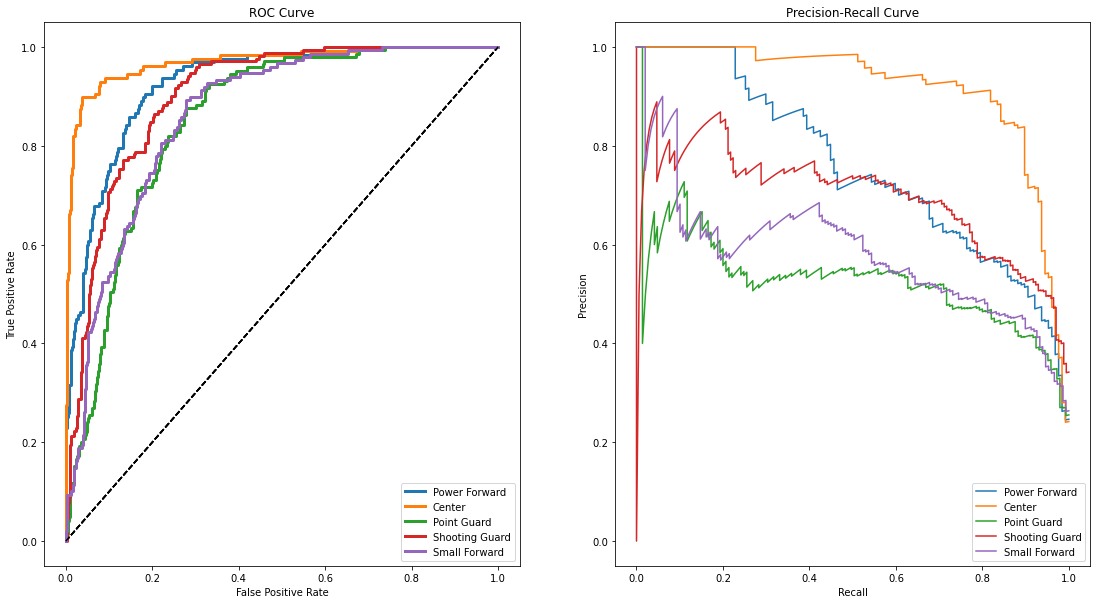

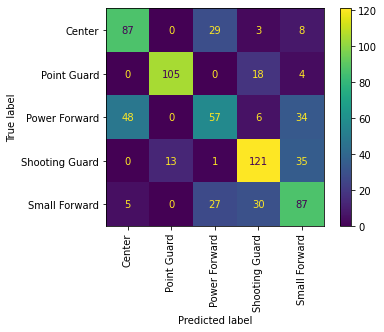

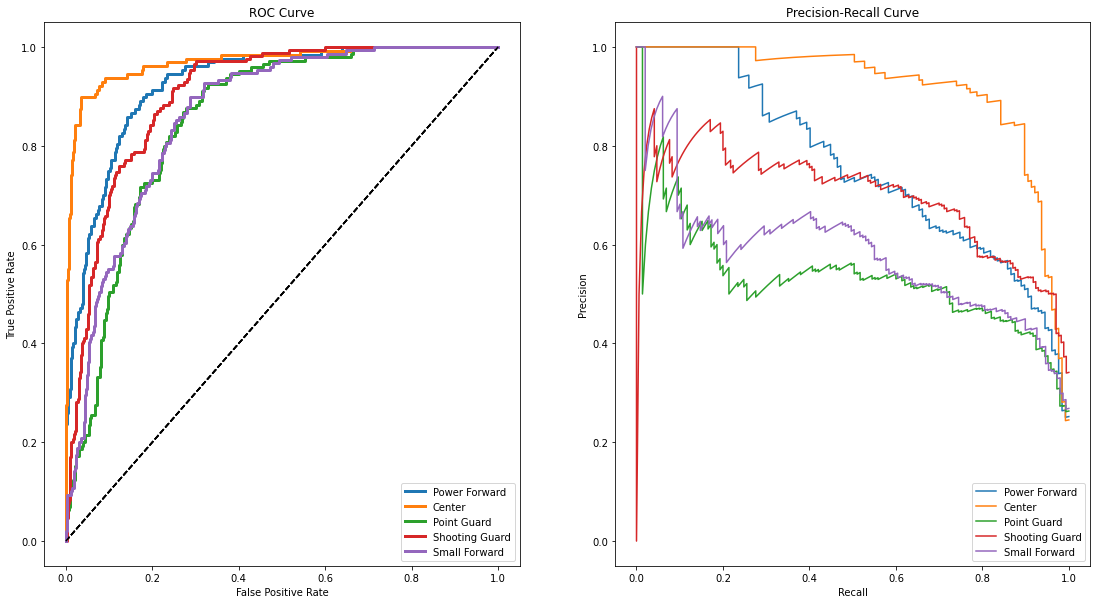

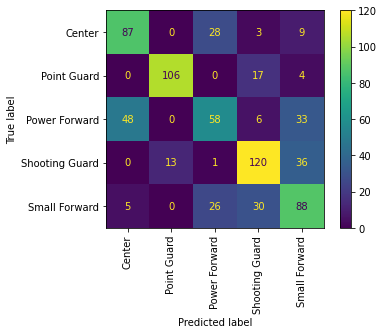

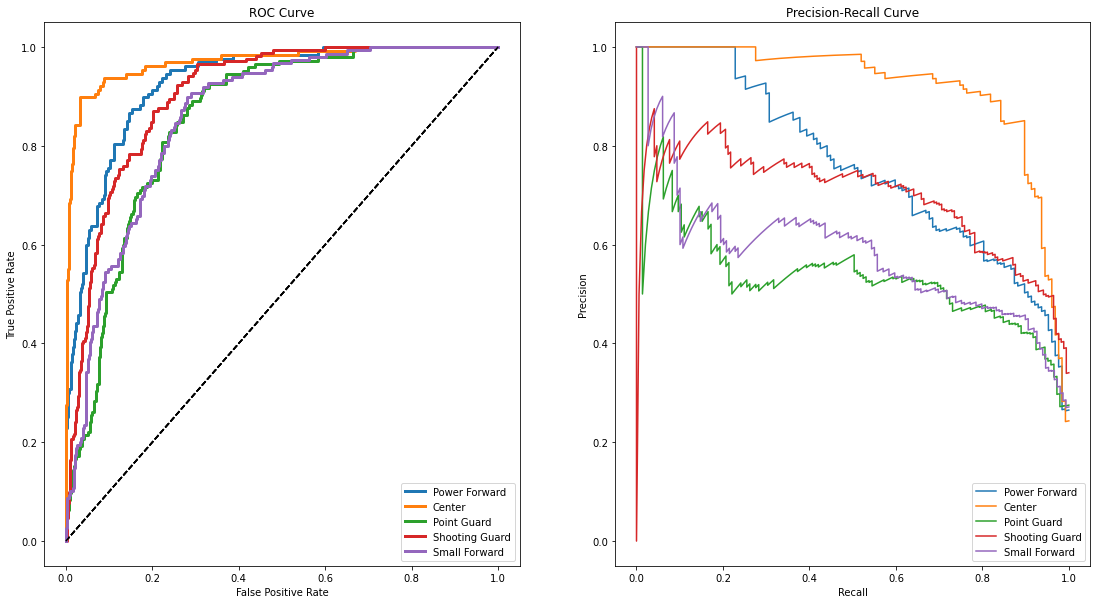

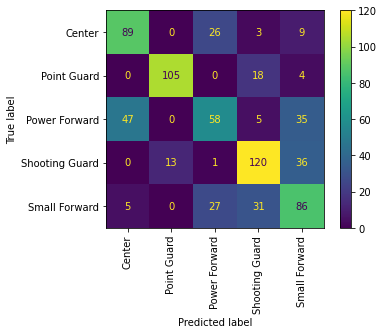

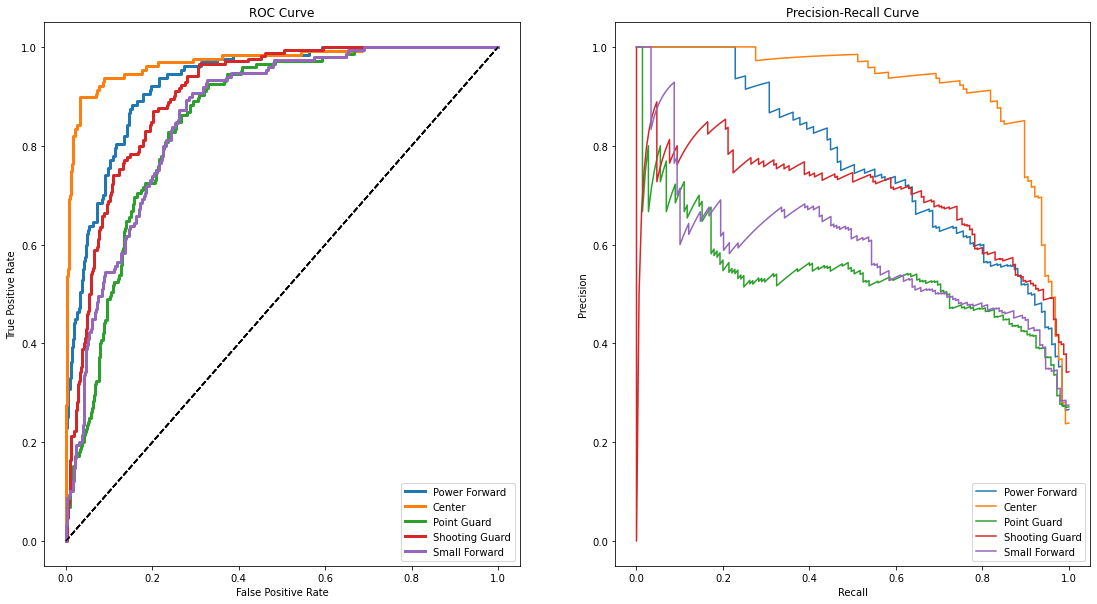

In [67]:
pick_k_lr(all_player_stats.drop(['Pos','Num_Pos','Target','Player'],axis=1),all_player_stats['Target'],10,['PTS', 'TRB', 'AST', 'STL', 'BLK','2PA','3PA','ORB','DRB'])

## Hyptertuning Our Best Model So Far

In [69]:
# RF and Log Reg did the best with the below 

df = all_player_stats.copy()
df['3PA'].replace({np.NaN: 0}, inplace = True)
model_features = ['PTS', 'TRB', 'AST', 'STL', 'BLK','2PA','3PA']
total_features = model_features + ['Target']
df = all_player_stats[total_features].dropna(axis=0)

X = df[model_features]
y = df['Target']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.20, random_state = 23, stratify = y)

In [70]:
#RF - 5 Main stats did the best

param_grid = {
    'max_depth': [5,10,15,20],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

rf = RandomForestClassifier()
# Instantiate the grid search model
rf_cv = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 2)

rf_cv.fit(X_train, y_train)
print("tuned hpyerparameters :(best parameters) ",rf_cv.best_params_)
print("accuracy :",rf_cv.best_score_)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits
tuned hpyerparameters :(best parameters)  {'max_depth': 15, 'max_features': 3, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}
accuracy : 0.6582959641255606


In [73]:
def pick_k_rf_hypertuned(X,y,n,model_features):
    
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.20, random_state = 23, stratify = y)
    
    scaler = StandardScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    imputer = KNNImputer(n_neighbors=n).fit(X_train_scaled)
    X_train_scaled_imputed = imputer.transform(X_train_scaled)
    X_test_scaled_imputed = imputer.transform(X_test_scaled)
    
    predicted_nans_X_train = pd.DataFrame(data=X_train_scaled_imputed, columns = X.columns)
    predicted_nans_X_test = pd.DataFrame(data=X_test_scaled_imputed, columns = X.columns)
    
    
    for n in range(1,n+1):
        imputer = KNNImputer(n_neighbors=n).fit(X_train_scaled)
        X_train_scaled_imputed = imputer.transform(X_train_scaled)
        X_test_scaled_imputed = imputer.transform(X_test_scaled)
    
        predicted_nans_X_train = pd.DataFrame(data=X_train_scaled_imputed, columns = X.columns)
        predicted_nans_X_test = pd.DataFrame(data=X_test_scaled_imputed, columns = X.columns)
        
        X_train_final = predicted_nans_X_train[model_features]
        X_test_final = predicted_nans_X_test[model_features]
        

        rf = RandomForestClassifier(max_depth = 15, max_features= 3, min_samples_leaf= 4, min_samples_split= 10, n_estimators= 300).fit(X_train_final,y_train)
        rf_predicted = rf.predict(X_test_final)

        print(f'train accuracy: {cross_val_score(rf,X_train_final,y_train,cv=5).mean()} | test accuracy cross val: {accuracy_score(y_test,rf_predicted)}');
        plot_confusion_matrix(rf,X_test_final,y_test,xticks_rotation='vertical')
        roc(rf, X_test_final, y_test)


In [96]:
#dropping nans
df = all_player_stats.copy()
df['3PA'].replace({np.NaN: 0}, inplace = True)
model_features = ['PTS', 'TRB', 'AST', 'STL', 'BLK','2PA','3PA']
total_features = model_features + ['Target']
df = all_player_stats[total_features].dropna(axis=0)

X = df[model_features]
y = df['Target']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.20, random_state = 23, stratify = y)


best_grid = rf_cv.best_estimator_
best_grid.score(X_test,y_test)

0.6182795698924731

train accuracy: 0.6203411604302378 | test accuracy cross val: 0.616991643454039
train accuracy: 0.6186002120890775 | test accuracy cross val: 0.616991643454039
train accuracy: 0.622778366914104 | test accuracy cross val: 0.6225626740947076
train accuracy: 0.6248707771549765 | test accuracy cross val: 0.6323119777158774
train accuracy: 0.6158109377367065 | test accuracy cross val: 0.6225626740947076
train accuracy: 0.6182505680957431 | test accuracy cross val: 0.6155988857938719
train accuracy: 0.6192946523254053 | test accuracy cross val: 0.6211699164345403
train accuracy: 0.6210325708226027 | test accuracy cross val: 0.6128133704735376
train accuracy: 0.6266062717770036 | test accuracy cross val: 0.6253481894150418
train accuracy: 0.625557945765793 | test accuracy cross val: 0.6267409470752089


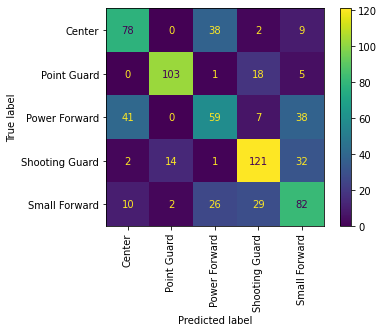

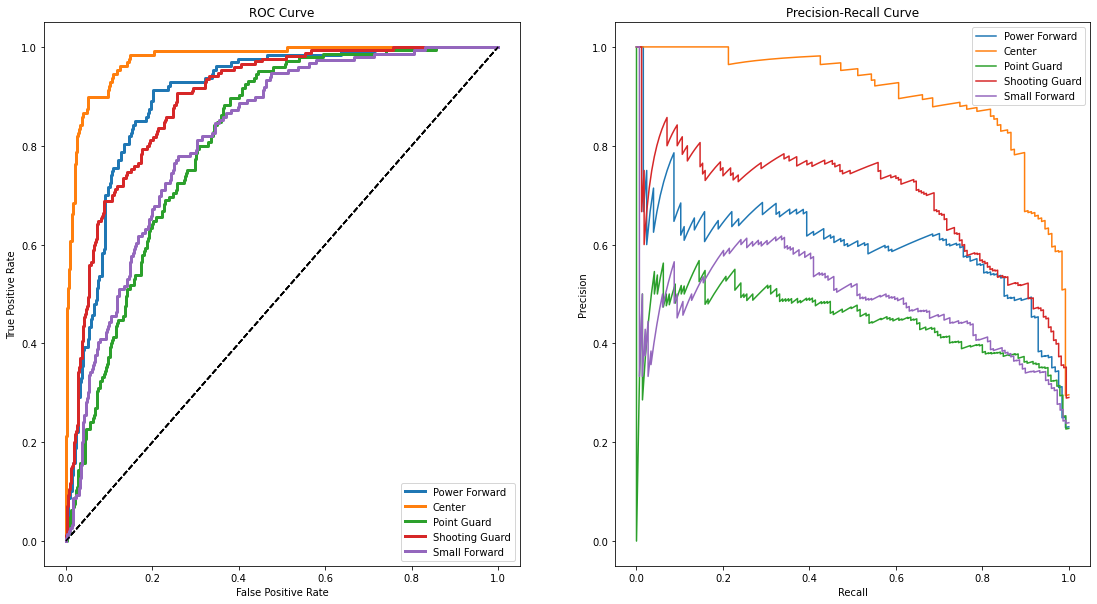

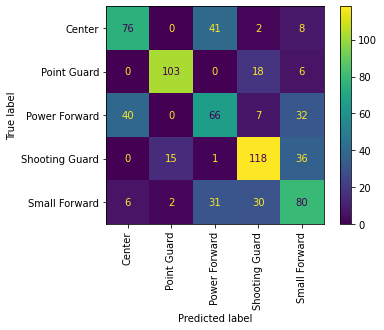

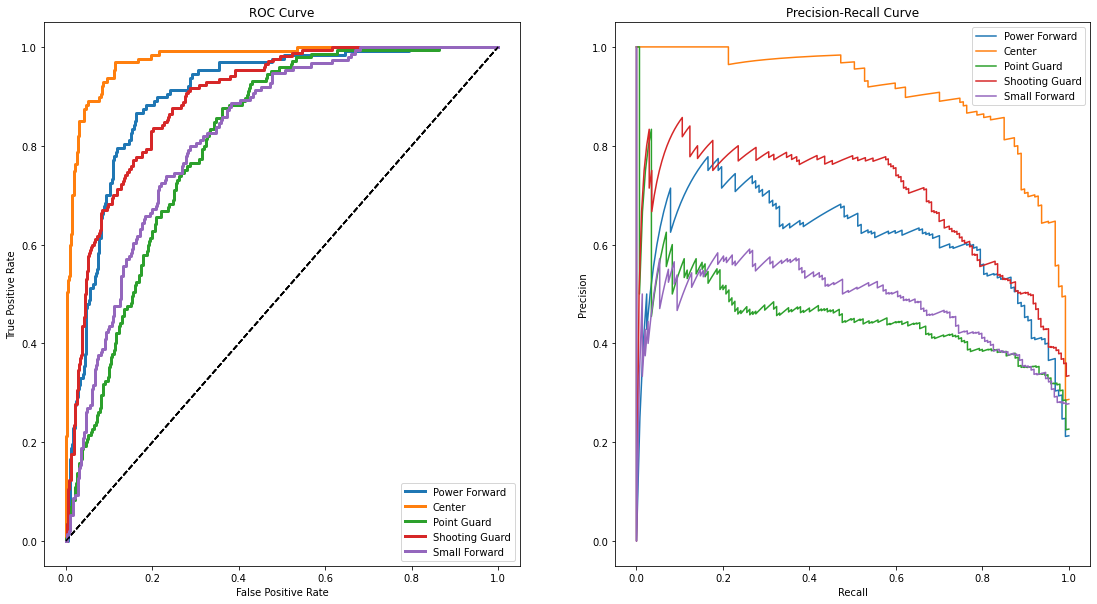

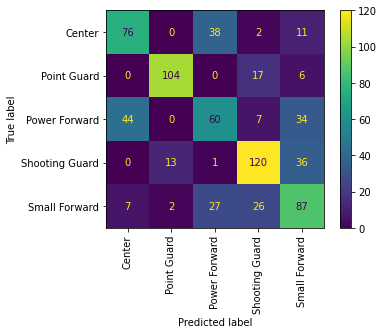

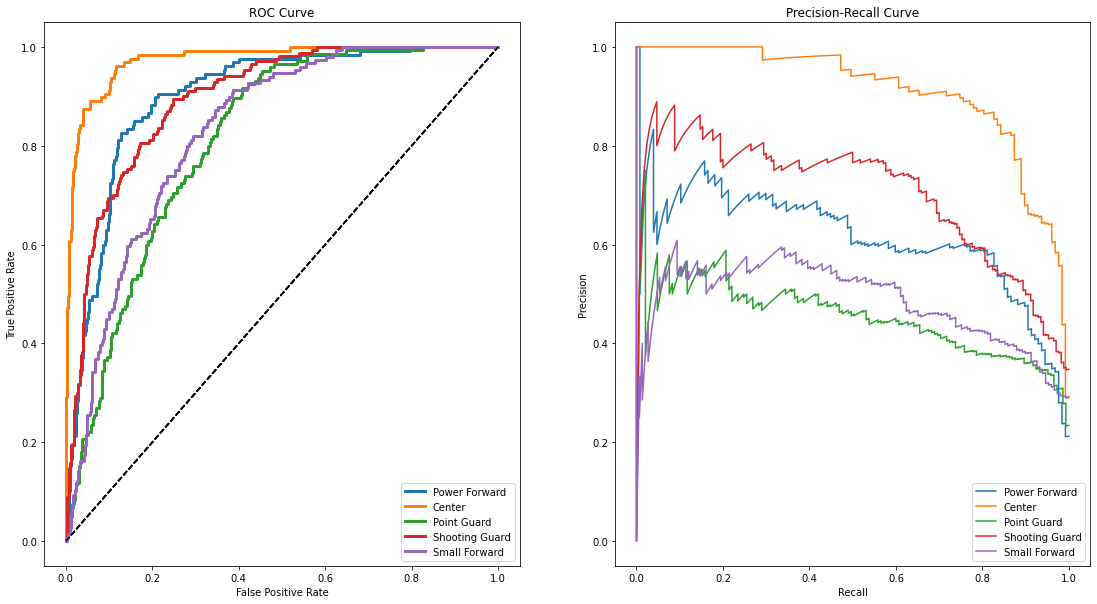

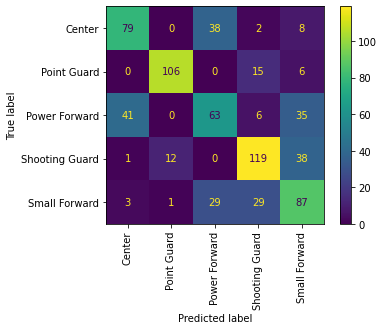

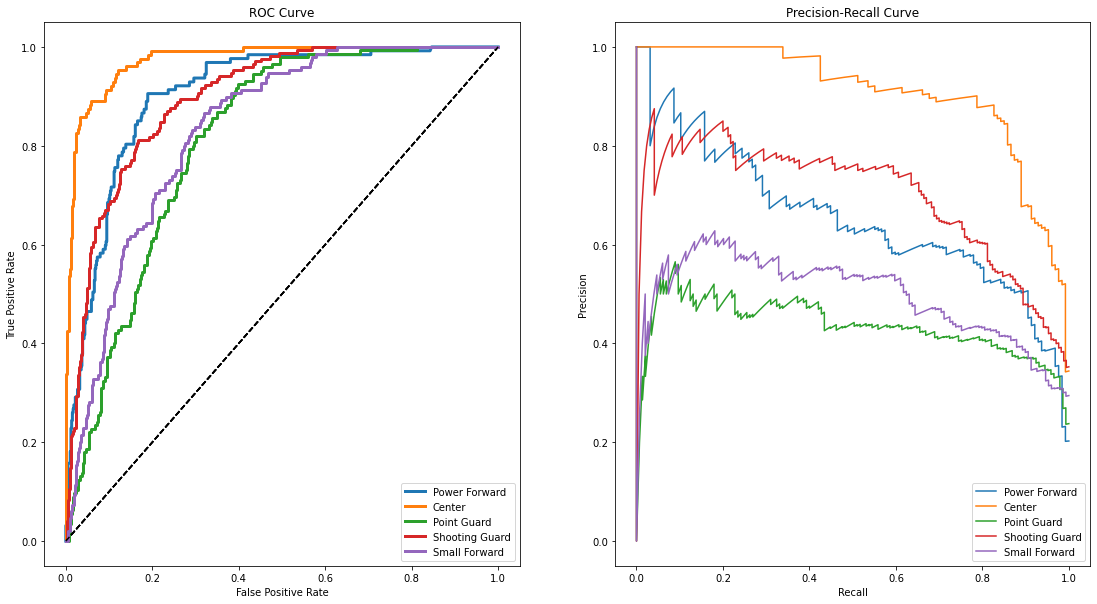

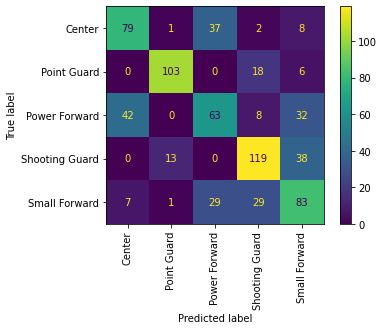

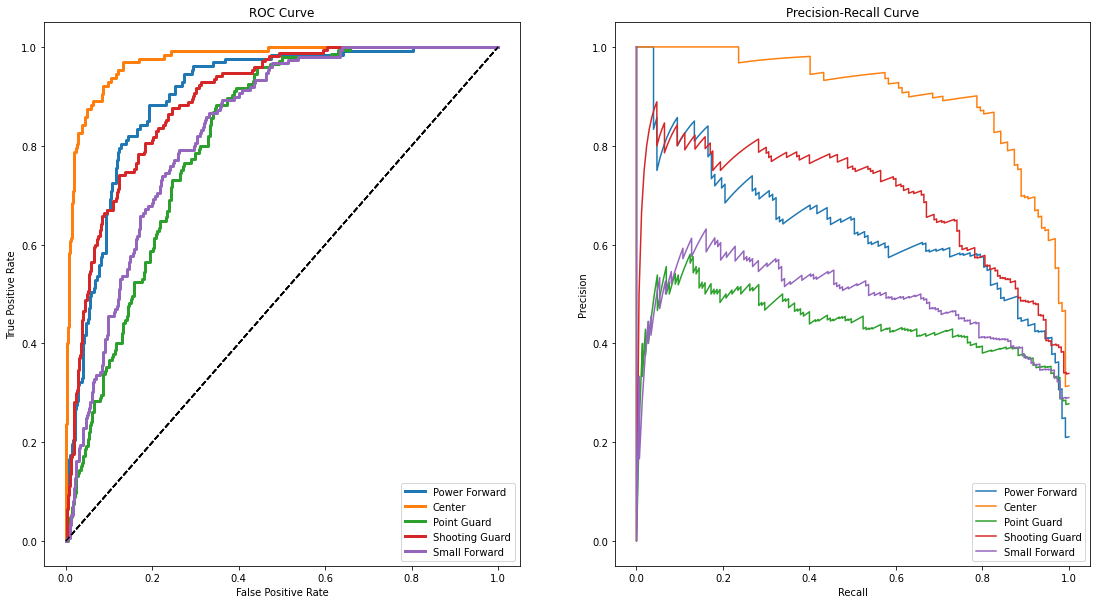

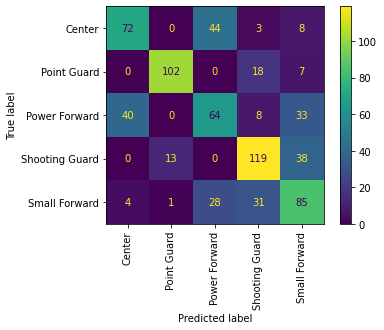

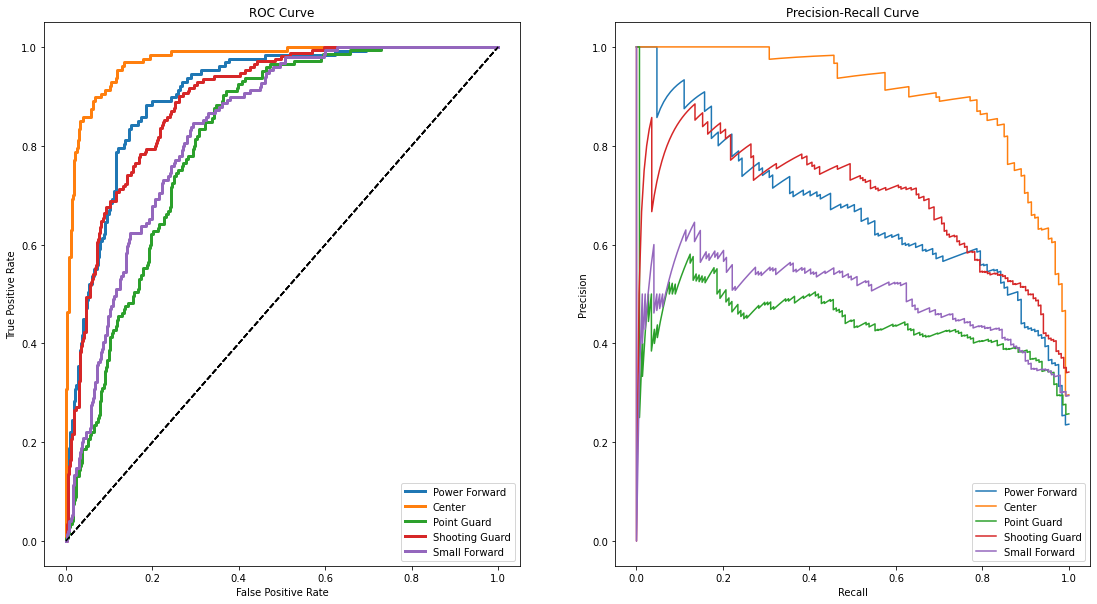

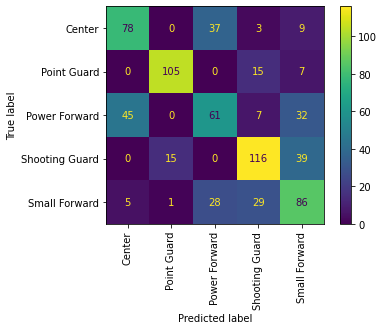

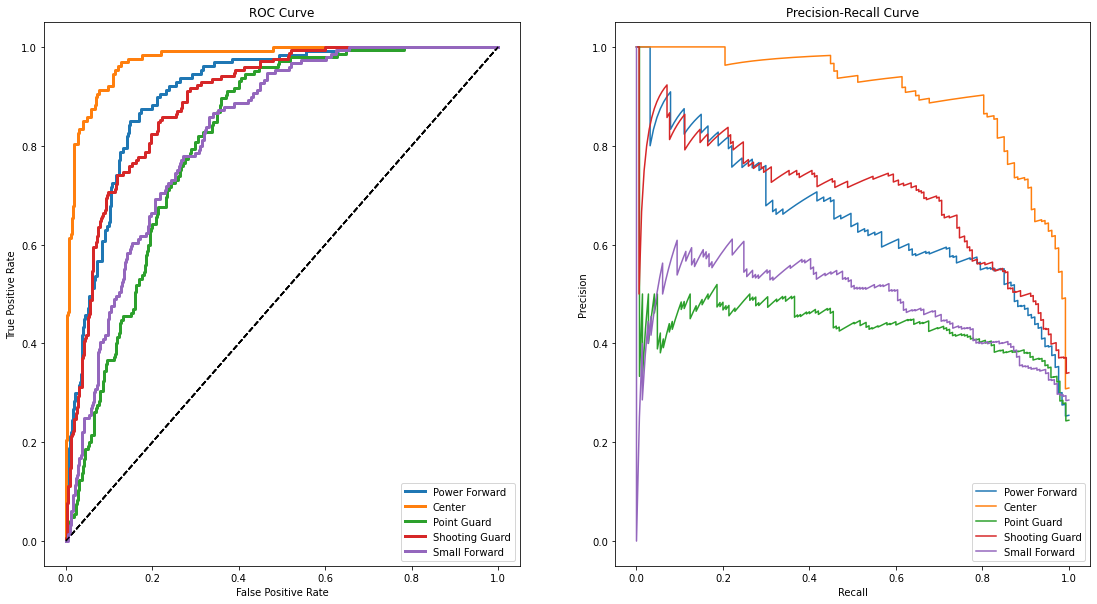

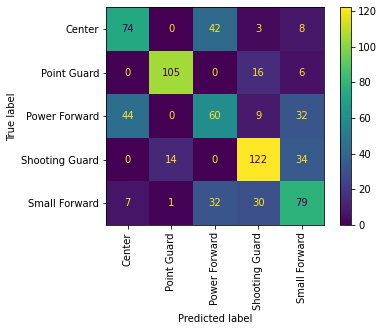

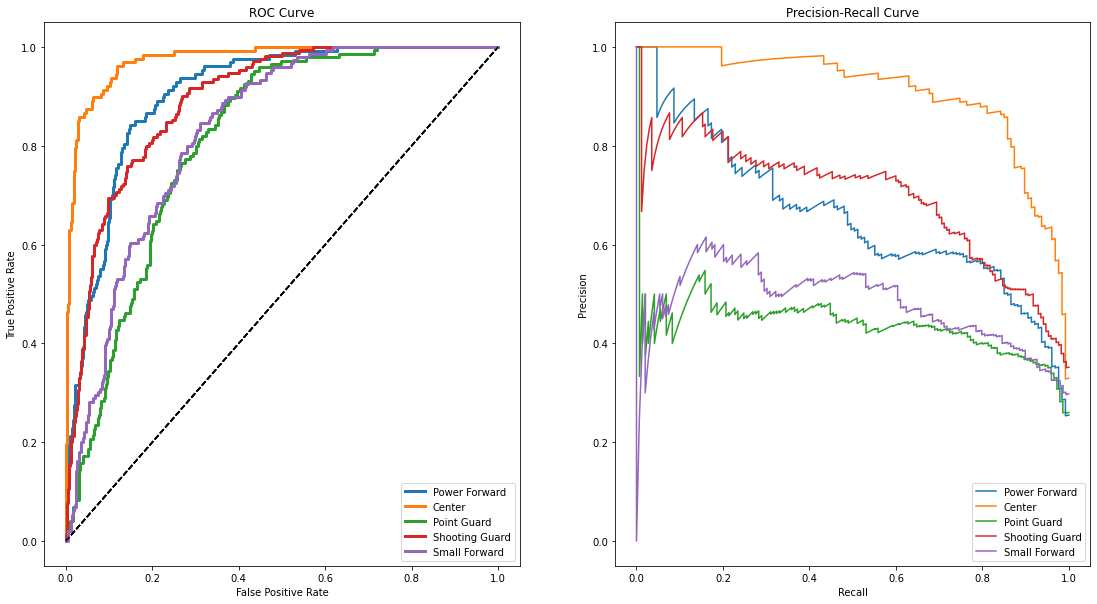

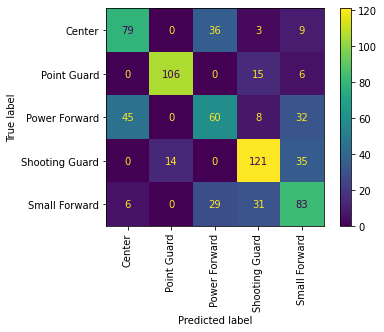

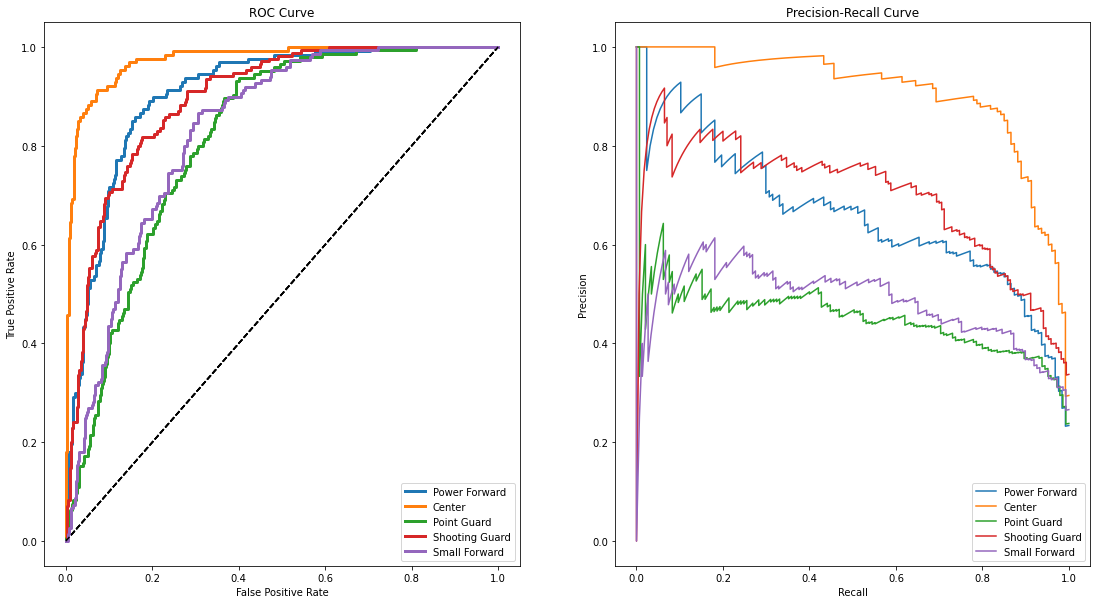

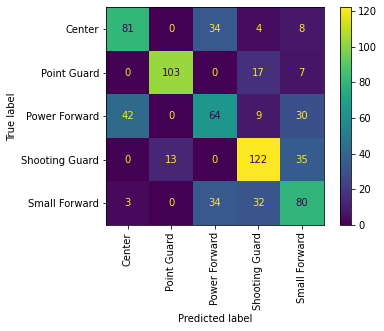

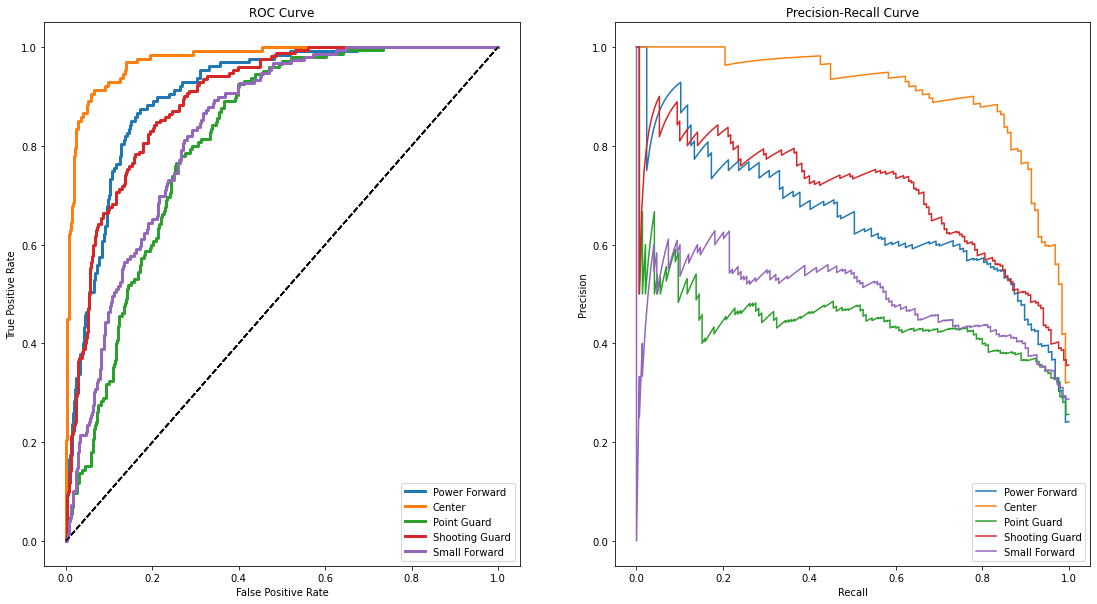

In [98]:
#filling in nans
df = all_player_stats.copy()
model_features = ['PTS', 'TRB', 'AST', 'STL', 'BLK','2PA','3PA']
total_features = model_features + ['Target']

X = df[model_features]
y = df['Target']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.20, random_state = 23, stratify = y)


pick_k_rf_hypertuned(X,y,10,model_features)

In [92]:
# Logistic Regression - dropping NaNs and adding in 3PA and 2PAs and changing 3PAs to 0s


df = all_player_stats.copy()
df['3PA'].replace({np.NaN: 0}, inplace = True)
model_features = ['PTS', 'TRB', 'AST', 'STL', 'BLK','2PA','3PA']
total_features = model_features + ['Target']
df = all_player_stats[total_features].dropna(axis=0)

X = df[model_features]
y = df['Target']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.20, random_state = 23, stratify = y)


grid={"C":[0.001,0.1,1,10,100,250,500,1000,2500,5000]}
logreg=LogisticRegression(max_iter=1000)
logreg_cv=GridSearchCV(logreg,grid,cv=5)

logreg_cv.fit(X_train,y_train)
print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 250}
accuracy : 0.6784753363228699


In [95]:
#dropping nans
df = all_player_stats.copy()
df['3PA'].replace({np.NaN: 0}, inplace = True)
model_features = ['PTS', 'TRB', 'AST', 'STL', 'BLK','2PA','3PA']
total_features = model_features + ['Target']
df = all_player_stats[total_features].dropna(axis=0)

X = df[model_features]
y = df['Target']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.20, random_state = 23, stratify = y)


best_logreg_grid = logreg_cv.best_estimator_
best_logreg_grid .score(X_test,y_test)

0.6594982078853047

In [99]:
def pick_k_lr_hypertuned(X,y,n,model_features):
    
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.20, random_state = 23, stratify = y)
    
    scaler = StandardScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    imputer = KNNImputer(n_neighbors=n).fit(X_train_scaled)
    X_train_scaled_imputed = imputer.transform(X_train_scaled)
    X_test_scaled_imputed = imputer.transform(X_test_scaled)
    
    predicted_nans_X_train = pd.DataFrame(data=X_train_scaled_imputed, columns = X.columns)
    predicted_nans_X_test = pd.DataFrame(data=X_test_scaled_imputed, columns = X.columns)
    
    
    for n in range(1,n+1):
        imputer = KNNImputer(n_neighbors=n).fit(X_train_scaled)
        X_train_scaled_imputed = imputer.transform(X_train_scaled)
        X_test_scaled_imputed = imputer.transform(X_test_scaled)
    
        predicted_nans_X_train = pd.DataFrame(data=X_train_scaled_imputed, columns = X.columns)
        predicted_nans_X_test = pd.DataFrame(data=X_test_scaled_imputed, columns = X.columns)
        
        X_train_final = predicted_nans_X_train[model_features]
        X_test_final = predicted_nans_X_test[model_features]
        


        lr = LogisticRegression(max_iter = 1000, C=250).fit(X_train_final,y_train)
        lr_predicted = lr.predict(X_test_final)

        print(f'train accuracy: {cross_val_score(lr,X_train_final,y_train,cv=5).mean()} | test accuracy cross val: {accuracy_score(y_test,lr_predicted)}');
        plot_confusion_matrix(lr,X_test_final,y_test,xticks_rotation='vertical')
        roc(lr, X_test_final, y_test)

train accuracy: 0.6335712770792304 | test accuracy cross val: 0.6392757660167131
train accuracy: 0.6342669292531434 | test accuracy cross val: 0.6309192200557103
train accuracy: 0.6353134373579762 | test accuracy cross val: 0.6295264623955432
train accuracy: 0.6360096955006818 | test accuracy cross val: 0.6309192200557103
train accuracy: 0.6401890622632934 | test accuracy cross val: 0.6309192200557103
train accuracy: 0.6384462960157552 | test accuracy cross val: 0.6253481894150418
train accuracy: 0.6387923041963338 | test accuracy cross val: 0.6239554317548747
train accuracy: 0.6377470080290865 | test accuracy cross val: 0.6267409470752089
train accuracy: 0.6391401302832904 | test accuracy cross val: 0.628133704735376
train accuracy: 0.6391419481896682 | test accuracy cross val: 0.6337047353760445


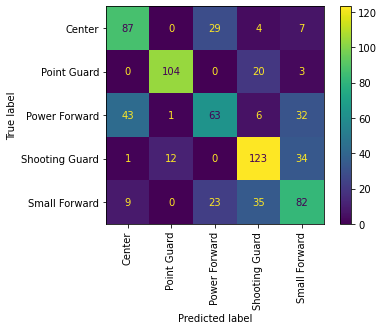

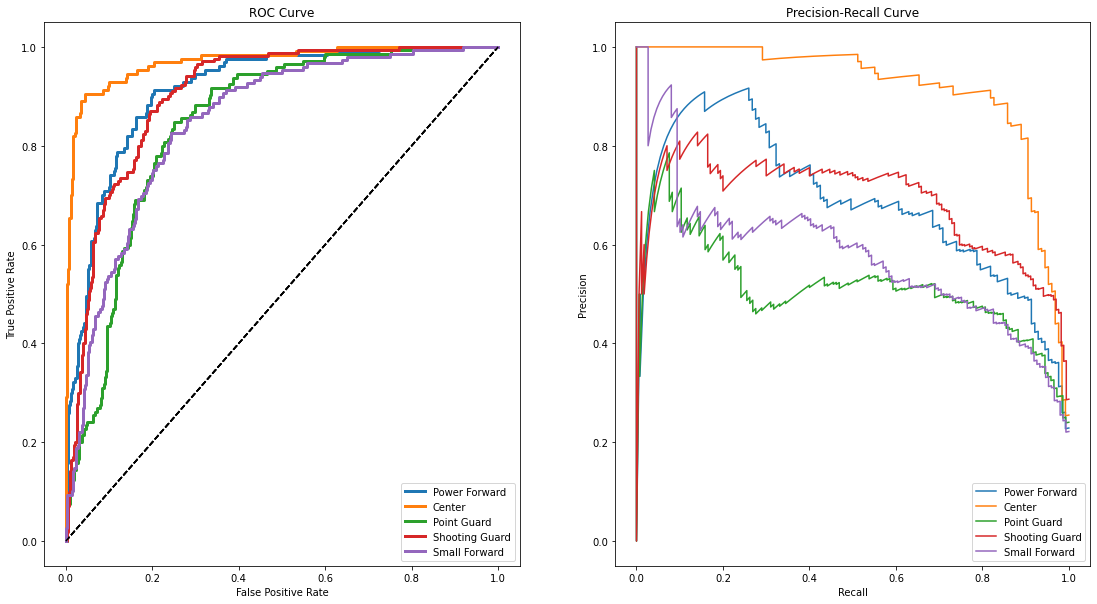

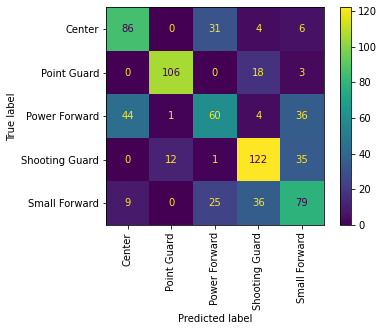

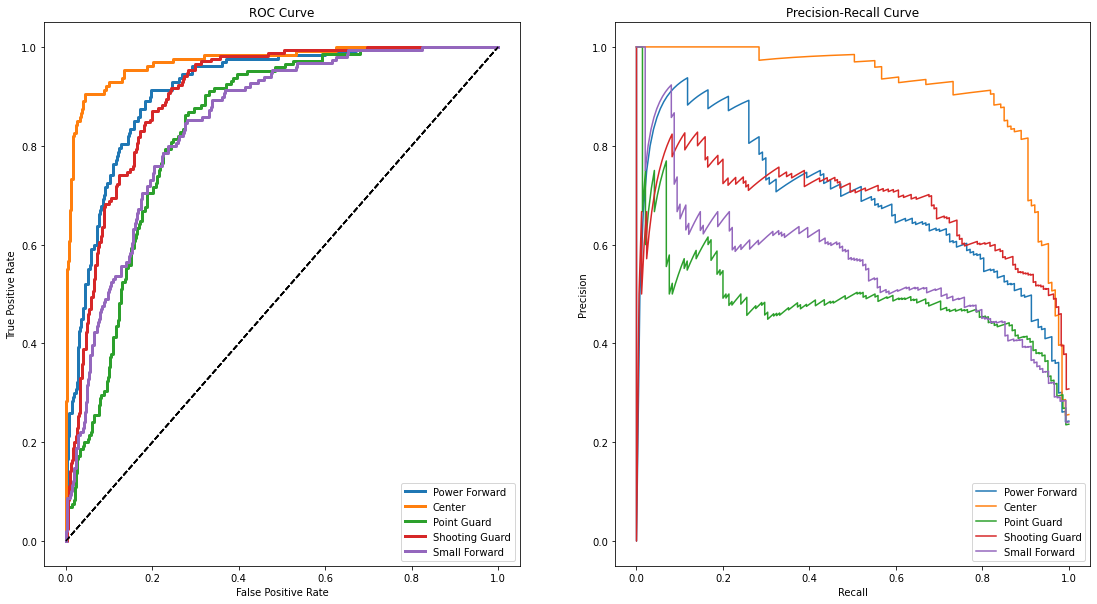

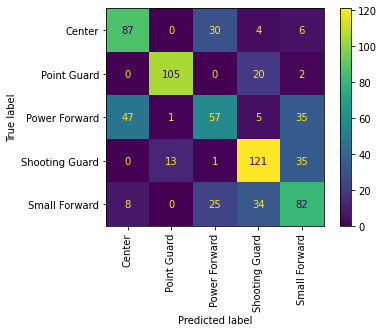

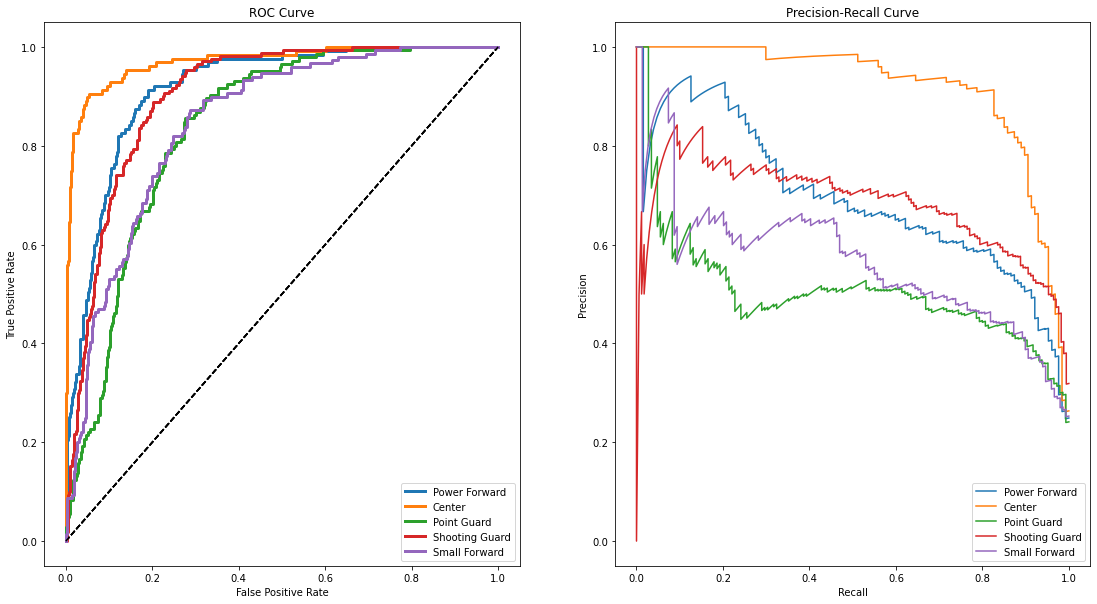

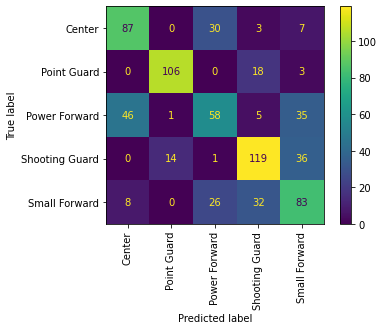

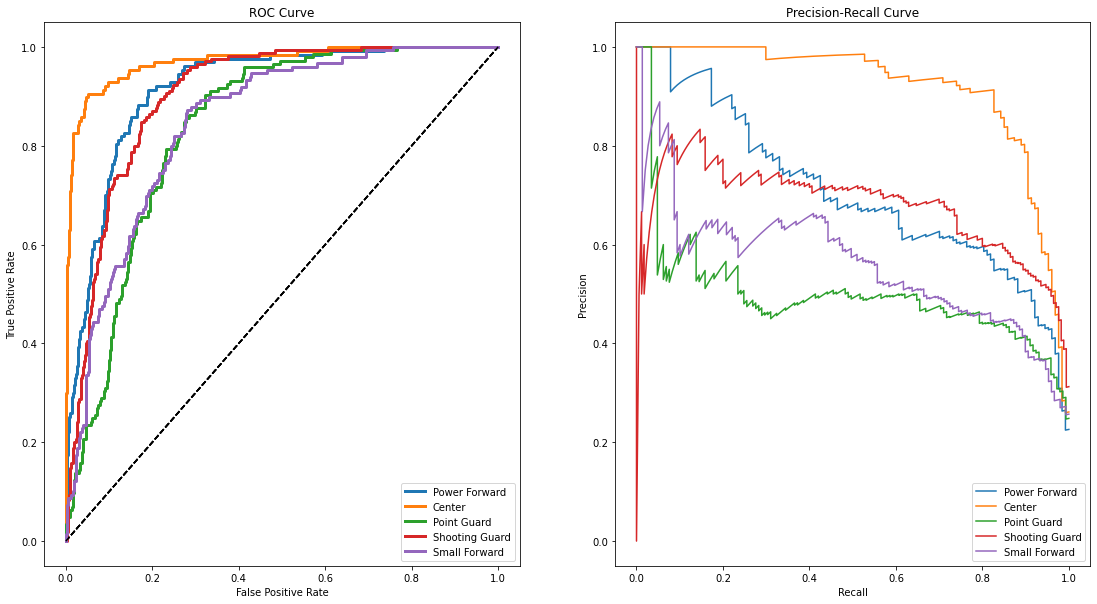

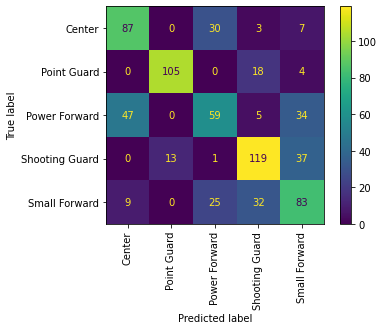

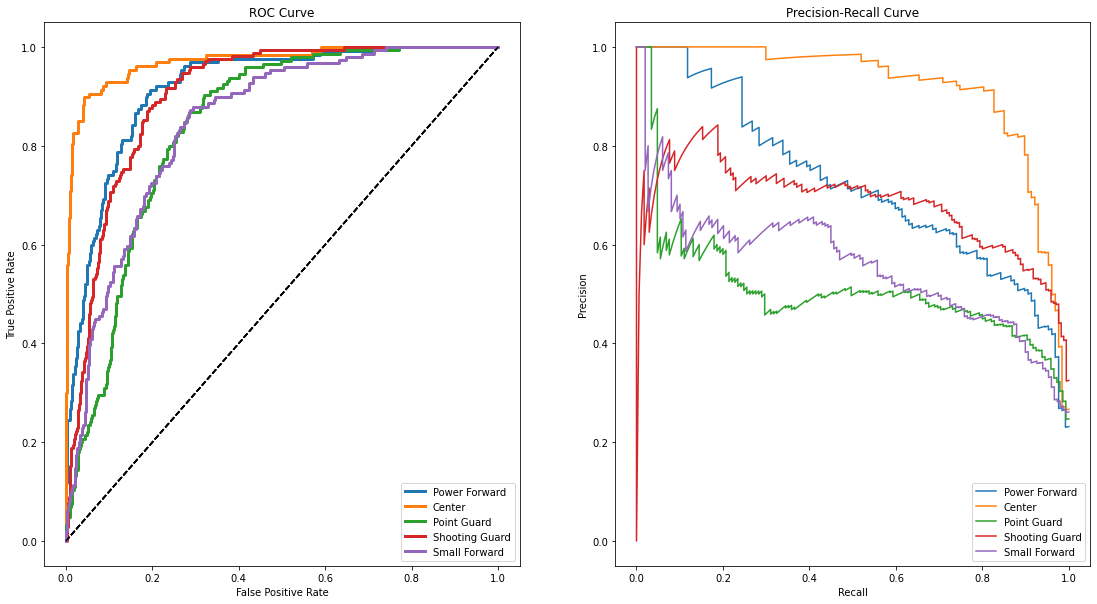

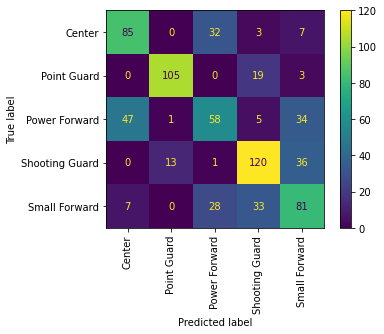

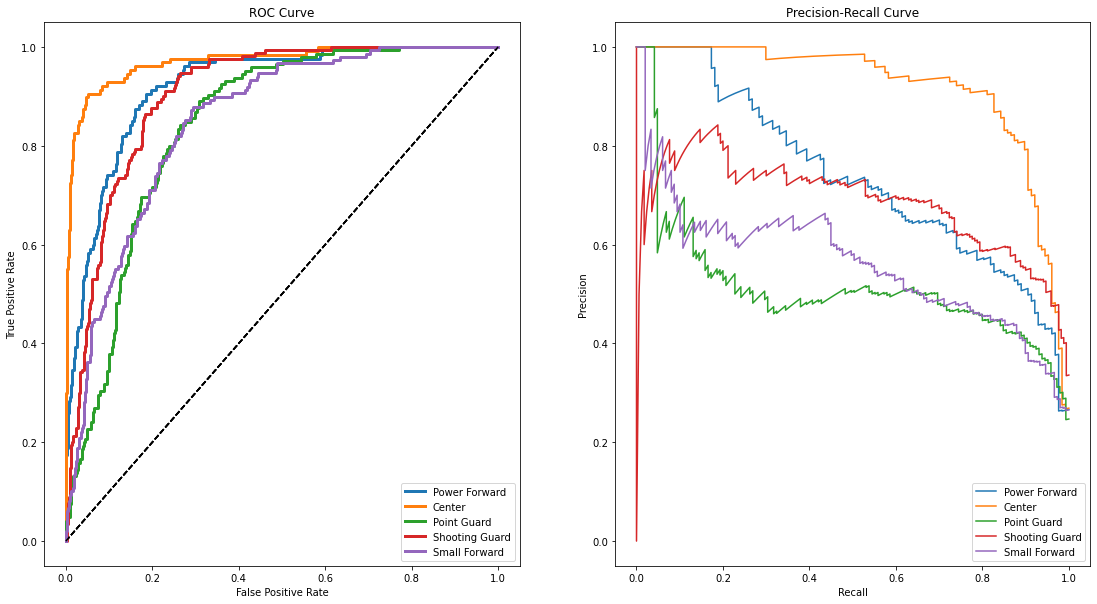

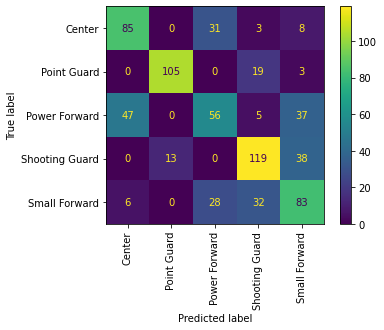

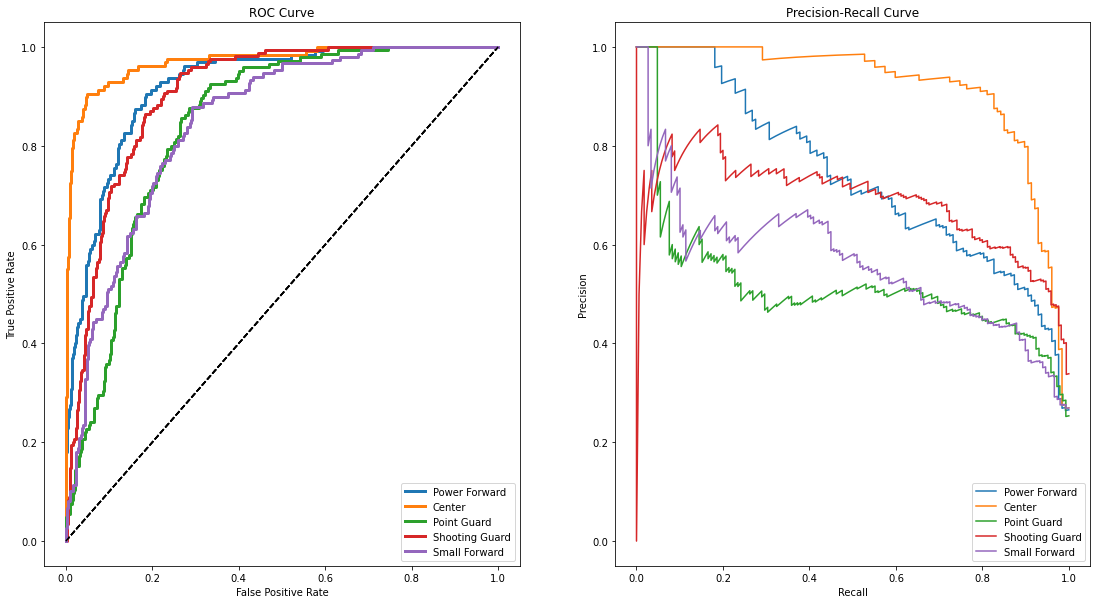

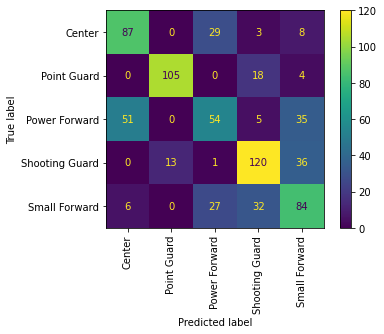

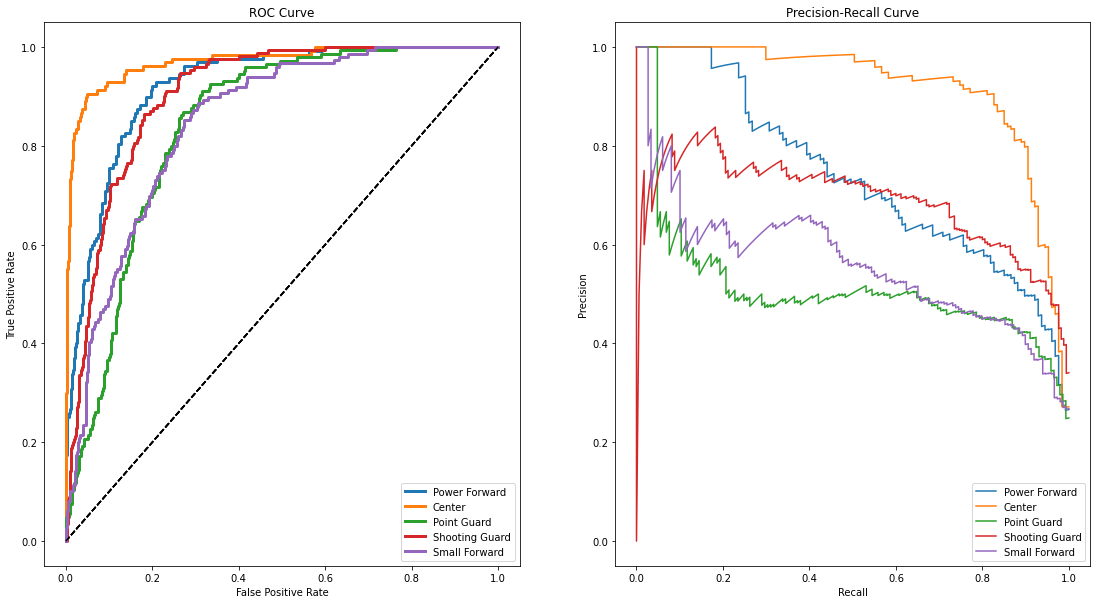

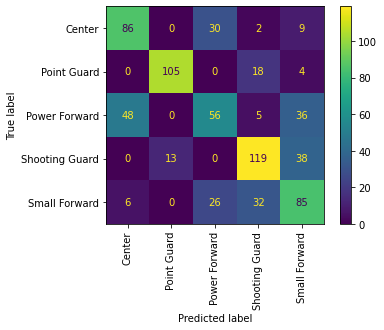

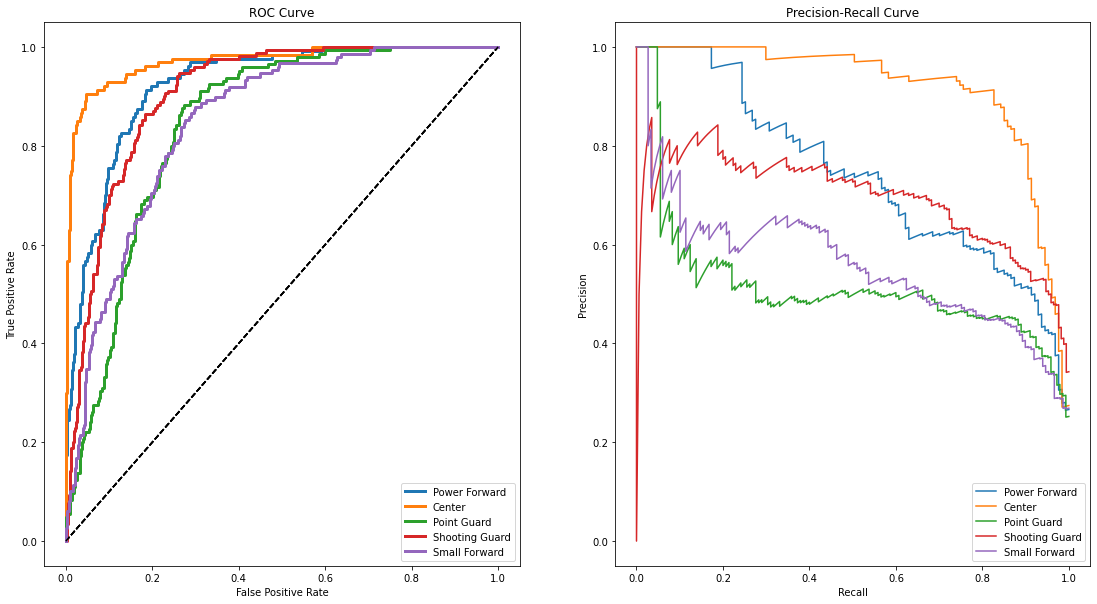

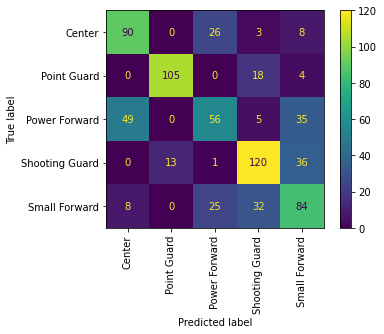

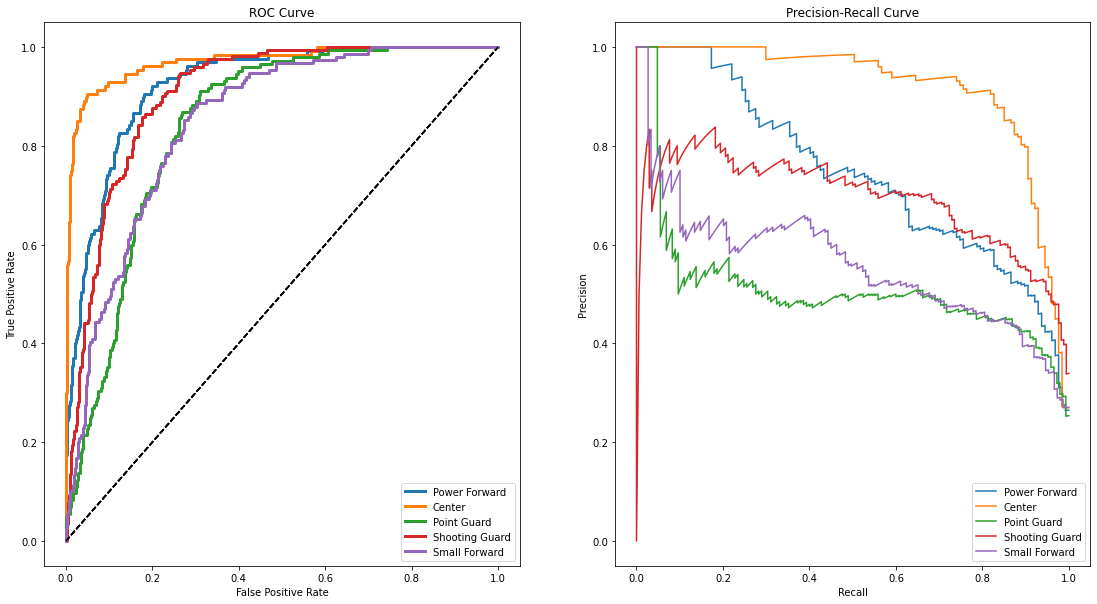

In [100]:
#filling in nans
df = all_player_stats.copy()
model_features = ['PTS', 'TRB', 'AST', 'STL', 'BLK','2PA','3PA']
total_features = model_features + ['Target']

X = df[model_features]
y = df['Target']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.20, random_state = 23, stratify = y)


pick_k_lr_hypertuned(X,y,10,model_features)